![logo](./img/LogoLine_horizon_C3S.png)

# Analyzing Ocean Colour and Sea Surface Temperature during El Niño and La Niña Events

This tutorial provides a practical introduction to daily **Ocean Colour (OC)** data (available from 1997 onward) and **Sea Surface Temperature (SST)** data (available from 1981 to 2016), both derived from satellite observations of the global ocean.

These datasets are freely accessible from the Climate Data Store (CDS) with a registered account.

In this example, we will use the variable `mass chlorophyll-a per unit volume of near-surface water` (mg m⁻³) from the OC dataset and the `Analysed SST` (K) from the SST dataset to compare **December values** during an **El Niño (2015)** year, a **La Niña (1999)** year, and a **neutral (2013)** year in the equatorial Pacific.

**Sea Surface Temperature** and **Chlorophyll-a concentration** are key indicators of oceanic conditions and are closely associated with El Niño and La Niña events. The gridded datasets from CDS support the examination of oceanic changes on different spatial scales on a daily basis and are available globally for both OC and SST.

For detailed information on the datasets, please visit the CDS website:
__[Daily Ocean Colour](https://cds.climate.copernicus.eu/datasets/satellite-ocean-colour?tab=overview")__ & __[Daily Sea Surface Temperature](https://cds.climate.copernicus.eu/datasets/satellite-sea-surface-temperature-ensemble-product?tab=overview)__

**Here, we provide step-by-step instructions on:**
1. Learn how to **subset and download** OC and SST datasets from CDS for December 1999, 2013 and 2015.
2. Examine the daily datasets downloaded
3. Extract daily `chl_a` and `analysed_SST` data to visualise **daily time series** for each variable comparing of all three years.
4. Aggregate the daily data to **monthly** NetCDF files.
5. Visualise monthly averaged values as maps to examine spatial change in distribution of `chl_a` and `analysed_SST`.
6. Calculate **anomalies** in December during El Niña and La Niña years compared to a "neutral" year and plot them in maps.<br>
***

## 1. Prerequisites and data preparations

This chapter provides information on how to run the notebook, the required Python libraries, and how to import them. It also guides you through the process of downloading the data via the CDS API.

### 1.1 How to run the notebook

#### Run the tutorial via free cloud platforms

This tutorial is in the form of a [Jupyter notebook](https://jupyter.org/). You will not need to install any software for the tutorial to run as there are a number of free cloud-based services to create, edit, run and export Jupyter notebooks such as this. Here are some suggestions (simply click on one of the links below to run the notebook):

<style>
td, th {
   border: 1px solid white;
   border-collapse: collapse;
}
</style>

<table align="left">
  <tr>
    <th><a href="https://kaggle.com/kernels/welcome?src=https://github.com/ecmwf-projects/copernicus-training-c3s/blob/main/ecv-notebooks/erb-outgoing-longwave-radiation.ipynb">
        <img src = "https://kaggle.com/static/images/open-in-kaggle.svg" alt = "Kaggle"></th>
    <th><a href="https://mybinder.org/v2/gh/ecmwf-projects/copernicus-training-c3s/main?labpath=ecv-notebooks/erb-outgoing-longwave-radiation.ipynb">
        <img src = "https://mybinder.org/badge.svg" alt = "Binder"></th>
    <th><a href="https://colab.research.google.com/github/ecmwf-projects/copernicus-training-c3s/blob/main/ecv-notebooks/erb-outgoing-longwave-radiation.ipynb">
        <img src = "https://colab.research.google.com/assets/colab-badge.svg" alt = "Colab"></th>
  </tr>
</table> Links to be changed

<br><br>

We are using `cdsapi` to download the data. This package is not yet included by default on most cloud platforms. You can use `pip` to install it:


```!pip install cdsapi```

***

#### Run the tutorial in local environment
If you would like to run this notebook in your own environment, we suggest you install [Anaconda](https://docs.anaconda.com/anaconda/install/), which is the easiest way to get all libraries installed.  

In this case, you can install the CDS API by using `conda` :<br>
```!conda install cdsapi```  

### 1.2 Python libraries

This tutorial is written in **Python** and requires basic Python knowledge and an environment that includes the following Python libraries:  

| Library   | Purpose |
|-----------|---------|
| **[cdsapi](https://pypi.org/project/cdsapi/)**  | Access and download data from the Copernicus Climate Data Store |
| **[os](https://docs.python.org/3/library/os.html)**  | Handle file and directory operations |
| **[zipfile](https://docs.python.org/3/library/zipfile.html)**  | Extract and manage ZIP archive files |
| **[xarray](https://xarray.dev/)**  | Work with multi-dimensional labeled datasets, commonly used for NetCDF files (format of OC and SST data from CDS) |
| **[glob](https://docs.python.org/3/library/glob.html)**  | Search for file paths using pattern matching |
| **[cartopy](https://scitools.org.uk/cartopy/docs/latest/)**  | Create maps and visualize geospatial data |
| **[matplotlib](https://matplotlib.org/stable/index.html)**  | Generate plots, charts, and visualizations |

In [20]:
!pip install numpy==1.26.4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 5.8 MB/s eta 0:00:00a 0:00:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
odc 0.1.0 requires numpy<3.0.0,>=2.1.1, but you have numpy 1.26.4 which is incompatible.


In [1]:
import cdsapi
import os
import zipfile

import xarray as xr
import glob

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import FuncFormatter
from matplotlib.colors import Normalize

In [15]:
!pip install cftime iris --upgrade

  Attempting uninstall: cftime
    Found existing installation: cftime 1.6.3
    Uninstalling cftime-1.6.3:
      Successfully uninstalled cftime-1.6.3


<div class="alert alert-block alert-warning">
If you run into errors try to install the missing library by using <b>!pip install "libary name"</b> or <b>!conda install "libary name"</b> (see table above).
</div>

### 1.3 Download data using the CDS API

In this section, we will focus on preparing the download from the CDS via the API. We will set up our CDA API credentials to be able to download the data from CDS, accept the Terms of Use to be able to get access to the datasets, define a subset and finally downloading the data.

#### Set up CDS API credentials

<div class="alert alert-block alert-warning">
<b>Without doing this step you can not proceed.</b> If you have already set up your CDS API credentials you can skip this part and move on to the next section "Accept Terms of Use".
</div>

Before downloading data from the CDS, you must set up your **CDS API credentials** and accept the **Terms of Use**. We will systematically request data from the CDS using the [CDS API](https://cds.climate.copernicus.eu/how-to-api) and for doing that, we need to set up our CDS credentials.  

The API credentials are stored in the `.cdsapirc` file located in your user folder (`Users/Username` on Windows, `$HOME/` on Linux). In this file, you need to copy and paste your `key` or ensure it is already present in the `.cdsapirc` file.

You can find your `key` and further instructions here (when logged in): [CDS API Instructions](https://cds.climate.copernicus.eu/how-to-api)  

**If you have not set up your CDS API credentials** using a `.cdsapirc` file, you can provide the credentials when initializing the `cdsapi.Client`. To do this, you must define two variables needed to establish a connection: `URL` and `KEY`.

- The `URL` for the CDS API is the same for all users and does not need to be modified.  
- The `KEY` is a string composed of your personal User ID and CDS API key.  

Replace the `##################################` below with your `key`.

In [2]:
if os.path.isfile("~/.cdsapirc"):
    cdsapi_kwargs = {}
else:
    URL = 'https: //cds.climate.copernicus.eu/api'
    KEY = '##################################'
    cdsapi_kwargs = {
        'url': URL,
        'key': KEY,
    }

***

#### Accept the Terms of Use

The final step before downloading the data is to **accept the Terms of Use**. Visit the dataset pages on the CDS website (__[OC](https://cds.climate.copernicus.eu/datasets/satellite-ocean-colour?tab=download)__ & __[SST](https://cds.climate.copernicus.eu/datasets/satellite-sea-surface-temperature-ensemble-product?tab=download)__), log in, scroll down to "Terms of Use," and accept them.  

Do this for both datasets, and you'll be ready to download the data via the CDS API.

***

#### Define subset area and years

In this tutorial, we will exploratively analyze two specific events (El Niño and La Niña) in an area of interest (the equatorial Pacific) and compare the results to a 'neutral' year to understand their impact on oceanic conditions. <br>

To do this, we will define the `years` and `area` for data download here:

In [3]:
# Define the years
# Here: 1999 La Nina; 2013 Neutral; 2015 El Nino
years = [1999, 2013, 2015]

# Define the region of interest
# Here: Pacific Ocean near South America to observe El Nino and La Nina events
# area = [North, West, South, East]
area = [20, -160, -20, -80]

***

#### Download daily data

There is a limit to how much data can be downloaded from the CDS at once. Since the OC and SST datasets are large, we will quickly reach this limit. You can check the limit manually by using the "Download" option on the dataset websites (right panel: "Request Validation": __[OC](https://cds.climate.copernicus.eu/datasets/satellite-ocean-colour?tab=download)__ & __[SST](https://cds.climate.copernicus.eu/datasets/satellite-sea-surface-temperature-ensemble-product?tab=download)__).  

To avoid downloading each dataset separately, we will automate the process by looping through each day, downloading and unzipping the data, and storing it locally.

The `OC` and `SST` data will be downloaded in a daily zip files containing a NetCDF file for each variable by default. We want to dowload the data, **unzip the daily NetCDF files** and **store them directly into monthly folders** for every year. 

Resulting in the following folder structure: 
- `data_cds_oc` --> `2015-12`, `2013-12` and `1999-12` (each containing 31 .nc files)
- `data_cds_sst` --> `2015-12`, `2013-12` and `1999-12` (each containing 31 .nc files)

<div class="alert alert-block alert-warning">
<b>Important Note:</b>  It will take approx. <b>30 mins to download OC data</b> and <b>30 mins to download SST data</b> for this tutorial's subset area and temporal selection of daily data for December 1999, 2013, and 2015. 

Please be aware that when selecting larger timeframes or areas, the download time could take even longer and could result in file sizes ≥ 1 GB.
</div>

##### Download Daily Ocean Colour data

Now we are ready to request the data via the CDS API and donwload the daily OC data for December of 1999, 2013 an 2015.

The request is defined by the following key variables:
- Product: `satellite-ocean-colour`
- Variable: `mass_concentration_of_chlorophyll_a` in mg m-3
- Year: `as defined above`
- Month: `12` for December of each year
- Day: `Range 1-32` for each day of December
- Area: `as defined above`
- Version: `6_0` for the most up to date version

In [4]:
# Create the base directory for data storage
base_dir = "data_cds_oc"
os.makedirs(base_dir, exist_ok=True)

# Initialize the CDS API client
client = cdsapi.Client()

# Loop through each year
for year in years:
    # Create a subfolder for the year and month (e.g. 1999-12)
    year_month_folder = os.path.join(base_dir, f"{year}-12")
    os.makedirs(year_month_folder, exist_ok=True)

    # Loop through each day in December (1 to 31)
    for day in range(1, 32):
        day_str = f"{day:02d}"

        # Request data for the current day
        request = {
            "variable": ["mass_concentration_of_chlorophyll_a"],
            "projection": "regular_latitude_longitude_grid",
            "year": [str(year)],
            "month": ["12"],
            "day": [day_str],
            "area": area,
            "version": "6_0"
        }

        # Download data for the current day and store it in the corresponding folder
        print(f"Downloading data for {year}-12-{day_str}...")
        download_path = os.path.join(
            year_month_folder, f"{year}_12_{day_str}.nc.zip"
        )
        client.retrieve(
            "satellite-ocean-colour",
            request,
            download_path,
            )

        # Unzip the downloaded file
        with zipfile.ZipFile(download_path, 'r') as zip_ref:
            zip_ref.extractall(year_month_folder)

        # Delete the original zip file after extraction
        os.remove(download_path)

        print(f"Data for {year}-12-{day_str} successfully downloaded and unzipped!")

print("All downloads are complete!")

2025-03-21 12:41:14,373 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-21 12:41:14,374 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.


2025-03-21 12:41:14,594 INFO Request ID is ffbb14c7-26aa-4c49-b270-18124bbcb49c
2025-03-21 12:41:14,781 INFO status has been updated to accepted
2025-03-21 12:41:23,284 INFO status has been updated to successful


290c921accad7c8bc3c8ed0bff9a8e5f.zip:   0%|          | 0.00/2.30M [00:00<?, ?B/s]

Data for 1999-12-01 successfully downloaded and unzipped!


2025-03-21 12:41:25,547 INFO Request ID is fee90bb7-00ce-4f97-925e-6d877befa844
2025-03-21 12:41:25,655 INFO status has been updated to accepted
2025-03-21 12:41:34,084 INFO status has been updated to successful


edbf36c2b6f91386cc96461d8b2ba335.zip:   0%|          | 0.00/2.52M [00:00<?, ?B/s]

2025-03-21 12:41:35,766 INFO Request ID is 7b146c5e-c2e0-445f-9168-5e8b60628887


Data for 1999-12-02 successfully downloaded and unzipped!


2025-03-21 12:41:35,827 INFO status has been updated to accepted
2025-03-21 12:41:44,265 INFO status has been updated to successful


232a8d85de971f7ca6a0a33b2f52349b.zip:   0%|          | 0.00/2.82M [00:00<?, ?B/s]

2025-03-21 12:41:46,295 INFO Request ID is 886ec977-82d3-4a51-86b9-e44e93b648ab


Data for 1999-12-03 successfully downloaded and unzipped!


2025-03-21 12:41:46,389 INFO status has been updated to accepted
2025-03-21 12:41:54,998 INFO status has been updated to running
2025-03-21 12:42:00,126 INFO status has been updated to successful


d409715af3d729634f89b2a1ff88fad5.zip:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

2025-03-21 12:42:01,743 INFO Request ID is 458826c7-7631-48bd-9e5b-4daaa0c83612


Data for 1999-12-04 successfully downloaded and unzipped!


2025-03-21 12:42:02,204 INFO status has been updated to accepted
2025-03-21 12:42:17,052 INFO status has been updated to successful


4584af5944c7e6c07498173159ccbc74.zip:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

2025-03-21 12:42:18,604 INFO Request ID is f80a3f29-6b4a-4f43-a0e0-0d0468c7cbb0


Data for 1999-12-05 successfully downloaded and unzipped!


2025-03-21 12:42:18,664 INFO status has been updated to accepted
2025-03-21 12:42:27,126 INFO status has been updated to successful


fd6be1894a850fe9128966f08362ee68.zip:   0%|          | 0.00/2.32M [00:00<?, ?B/s]

2025-03-21 12:42:28,912 INFO Request ID is 11dd9084-87e7-417c-8f30-4f01840152bd


Data for 1999-12-06 successfully downloaded and unzipped!


2025-03-21 12:42:28,998 INFO status has been updated to accepted
2025-03-21 12:42:37,498 INFO status has been updated to successful


9885e6d53d7b55efc1379a08085ebdb0.zip:   0%|          | 0.00/2.47M [00:00<?, ?B/s]

2025-03-21 12:42:39,231 INFO Request ID is 0da5b41b-6a9c-4e47-808e-bb24714ed7ef


Data for 1999-12-07 successfully downloaded and unzipped!


2025-03-21 12:42:39,296 INFO status has been updated to accepted
2025-03-21 12:42:47,727 INFO status has been updated to running
2025-03-21 12:42:52,876 INFO status has been updated to successful


8f8dd7eabfbe030333844093833c7906.zip:   0%|          | 0.00/2.74M [00:00<?, ?B/s]

2025-03-21 12:42:54,541 INFO Request ID is 6e97f3bb-505b-4ace-b476-07cdc745074b


Data for 1999-12-08 successfully downloaded and unzipped!


2025-03-21 12:42:54,619 INFO status has been updated to accepted
2025-03-21 12:43:15,885 INFO status has been updated to running
2025-03-21 12:43:27,346 INFO status has been updated to successful


94fb0e3eb4882df687ebc193466b2c7.zip:   0%|          | 0.00/2.44M [00:00<?, ?B/s]

Data for 1999-12-09 successfully downloaded and unzipped!


2025-03-21 12:43:29,197 INFO Request ID is 3e3c603d-95b1-462f-9e2c-31fac23c7d8c
2025-03-21 12:43:29,275 INFO status has been updated to accepted
2025-03-21 12:43:37,766 INFO status has been updated to successful


b7782883b598c4ca460332518df29d13.zip:   0%|          | 0.00/2.65M [00:00<?, ?B/s]

Data for 1999-12-10 successfully downloaded and unzipped!


2025-03-21 12:43:39,433 INFO Request ID is 4c42e10b-47e5-463d-8271-5940b2e2b6c0
2025-03-21 12:43:39,549 INFO status has been updated to accepted
2025-03-21 12:43:44,543 INFO status has been updated to running
2025-03-21 12:43:47,994 INFO status has been updated to successful


fb8d5db7fe39d15bcc1ca103f0acc5ac.zip:   0%|          | 0.00/2.14M [00:00<?, ?B/s]

2025-03-21 12:43:49,410 INFO Request ID is c4b52be7-b36e-4fdc-b810-b8ed5ecf7b2a


Data for 1999-12-11 successfully downloaded and unzipped!


2025-03-21 12:43:49,616 INFO status has been updated to accepted
2025-03-21 12:43:58,185 INFO status has been updated to successful


5c84bf3c0a669d67b31e8766914c35c.zip:   0%|          | 0.00/2.68M [00:00<?, ?B/s]

2025-03-21 12:43:59,771 INFO Request ID is 2a769c22-ba2a-4c50-8e63-2a87d6c9d589


Data for 1999-12-12 successfully downloaded and unzipped!


2025-03-21 12:43:59,832 INFO status has been updated to accepted
2025-03-21 12:44:08,273 INFO status has been updated to successful


1bce22ec0f24e3e0f9aee8066196397d.zip:   0%|          | 0.00/2.32M [00:00<?, ?B/s]

2025-03-21 12:44:09,908 INFO Request ID is 9a75c283-250e-48db-8fac-9e6edd0bf068


Data for 1999-12-13 successfully downloaded and unzipped!


2025-03-21 12:44:09,977 INFO status has been updated to accepted
2025-03-21 12:44:18,480 INFO status has been updated to successful


3a05a26aec091b5a204fc8dd843ea82d.zip:   0%|          | 0.00/2.56M [00:00<?, ?B/s]

2025-03-21 12:44:20,444 INFO Request ID is 30476eb9-a1a8-49c1-8935-5f90c3b1487e


Data for 1999-12-14 successfully downloaded and unzipped!


2025-03-21 12:44:20,523 INFO status has been updated to accepted
2025-03-21 12:44:29,059 INFO status has been updated to successful


eee619ccc9b294479b5f11985dae4a7a.zip:   0%|          | 0.00/2.81M [00:00<?, ?B/s]

2025-03-21 12:44:30,910 INFO Request ID is 82033b87-12fa-4ccd-9424-80f050c9c677


Data for 1999-12-15 successfully downloaded and unzipped!


2025-03-21 12:44:30,984 INFO status has been updated to accepted
2025-03-21 12:44:35,957 INFO status has been updated to successful


3c6151a4484753f230df49799ea60f58.zip:   0%|          | 0.00/2.69M [00:00<?, ?B/s]

Data for 1999-12-16 successfully downloaded and unzipped!


2025-03-21 12:44:38,248 INFO Request ID is ba10562a-cf6d-4ad1-93b9-82ad52377267
2025-03-21 12:44:38,308 INFO status has been updated to accepted
2025-03-21 12:44:43,342 INFO status has been updated to successful


645721a427169c7a9542371b079c32e8.zip:   0%|          | 0.00/2.48M [00:00<?, ?B/s]

2025-03-21 12:44:45,119 INFO Request ID is cffaae36-cf2f-4891-ab67-6278d46a702b


Data for 1999-12-17 successfully downloaded and unzipped!


2025-03-21 12:44:45,192 INFO status has been updated to accepted
2025-03-21 12:44:55,276 INFO status has been updated to successful


258c9cd2b835262f55d6af9a4e15a72a.zip:   0%|          | 0.00/2.25M [00:00<?, ?B/s]

2025-03-21 12:44:56,867 INFO Request ID is 0499e7e8-96b8-4751-ae2e-61d3ea70959b


Data for 1999-12-18 successfully downloaded and unzipped!


2025-03-21 12:44:56,944 INFO status has been updated to accepted
2025-03-21 12:45:05,460 INFO status has been updated to successful


9773d54279a2551ba33e3c620756be86.zip:   0%|          | 0.00/2.92M [00:00<?, ?B/s]

Data for 1999-12-19 successfully downloaded and unzipped!


2025-03-21 12:45:07,150 INFO Request ID is c2798ed6-116d-4a93-93d4-f53c8cca019c
2025-03-21 12:45:07,221 INFO status has been updated to accepted
2025-03-21 12:45:12,207 INFO status has been updated to successful


4cba17a3e1c7f9981a05e5cb85376441.zip:   0%|          | 0.00/2.71M [00:00<?, ?B/s]

Data for 1999-12-20 successfully downloaded and unzipped!


2025-03-21 12:45:13,867 INFO Request ID is 3aecbff6-818e-491f-a179-7062acf94e09
2025-03-21 12:45:13,932 INFO status has been updated to accepted
2025-03-21 12:45:18,914 INFO status has been updated to running
2025-03-21 12:45:22,362 INFO status has been updated to successful


a8a725f5084cad9f53fb6c9537b2010c.zip:   0%|          | 0.00/2.80M [00:00<?, ?B/s]

2025-03-21 12:45:23,974 INFO Request ID is b3496eea-5689-4dac-8090-87649a6821fa


Data for 1999-12-21 successfully downloaded and unzipped!


2025-03-21 12:45:24,099 INFO status has been updated to accepted
2025-03-21 12:45:29,111 INFO status has been updated to running
2025-03-21 12:45:33,468 INFO status has been updated to successful


3ec8c4ed39b1d2fd4e7d4ad516a79122.zip:   0%|          | 0.00/2.57M [00:00<?, ?B/s]

2025-03-21 12:45:35,246 INFO Request ID is 50ba55a4-18e9-4218-8224-3f49067fb88e


Data for 1999-12-22 successfully downloaded and unzipped!


2025-03-21 12:45:35,308 INFO status has been updated to accepted
2025-03-21 12:45:40,269 INFO status has been updated to successful


88dfdc5648b35c83b5facd3a0ab14c6e.zip:   0%|          | 0.00/2.61M [00:00<?, ?B/s]

Data for 1999-12-23 successfully downloaded and unzipped!


2025-03-21 12:45:41,838 INFO Request ID is 433f2227-3935-4f3a-9608-02717ea5327d
2025-03-21 12:45:41,916 INFO status has been updated to accepted
2025-03-21 12:45:46,888 INFO status has been updated to running
2025-03-21 12:45:50,395 INFO status has been updated to successful


f0433621a9c5fad51e4be16dd72ea116.zip:   0%|          | 0.00/2.66M [00:00<?, ?B/s]

Data for 1999-12-24 successfully downloaded and unzipped!


2025-03-21 12:45:52,095 INFO Request ID is 2a6566a7-bfda-4259-898d-54ff013fa9be
2025-03-21 12:45:52,171 INFO status has been updated to accepted
2025-03-21 12:45:57,136 INFO status has been updated to running
2025-03-21 12:46:00,603 INFO status has been updated to successful


c7e2231b5c6ecbaede0aa6e715600b49.zip:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

2025-03-21 12:46:02,446 INFO Request ID is 0e901b25-4afc-4130-889f-b4691747c087


Data for 1999-12-25 successfully downloaded and unzipped!


2025-03-21 12:46:02,523 INFO status has been updated to accepted
2025-03-21 12:46:07,558 INFO status has been updated to successful


6f15a50aaaa082c74be683ae715e113e.zip:   0%|          | 0.00/2.75M [00:00<?, ?B/s]

Data for 1999-12-26 successfully downloaded and unzipped!


2025-03-21 12:46:09,049 INFO Request ID is 681f936b-259a-4482-8ca6-503201010884
2025-03-21 12:46:09,116 INFO status has been updated to accepted
2025-03-21 12:46:14,069 INFO status has been updated to running
2025-03-21 12:46:17,722 INFO status has been updated to successful


b590d4e846a0d53a0ea908fab3e8fe3b.zip:   0%|          | 0.00/2.80M [00:00<?, ?B/s]

Data for 1999-12-27 successfully downloaded and unzipped!


2025-03-21 12:46:19,200 INFO Request ID is c342f57f-b340-43e3-9189-cfcb6fef4935
2025-03-21 12:46:19,262 INFO status has been updated to accepted
2025-03-21 12:46:24,230 INFO status has been updated to running
2025-03-21 12:46:27,667 INFO status has been updated to successful


b8a5238ca22d0c1f60f86dce9c385463.zip:   0%|          | 0.00/3.23M [00:00<?, ?B/s]

2025-03-21 12:46:29,572 INFO Request ID is f726bdce-964a-4f61-bbee-c7a1ee978625


Data for 1999-12-28 successfully downloaded and unzipped!


2025-03-21 12:46:29,746 INFO status has been updated to accepted
2025-03-21 12:46:34,698 INFO status has been updated to successful


ecd525cc9613fca4d534f51015fce228.zip:   0%|          | 0.00/3.08M [00:00<?, ?B/s]

2025-03-21 12:46:36,215 INFO Request ID is 8e36b99a-081d-44fc-8f98-2080fc1f9499


Data for 1999-12-29 successfully downloaded and unzipped!


2025-03-21 12:46:36,283 INFO status has been updated to accepted
2025-03-21 12:46:41,386 INFO status has been updated to successful


74df32ad24f566d6a3912d3b5564cef3.zip:   0%|          | 0.00/3.41M [00:00<?, ?B/s]

Data for 1999-12-30 successfully downloaded and unzipped!


2025-03-21 12:46:43,433 INFO Request ID is 1e674ba2-4790-43ab-a6b0-00d4a5dad8af
2025-03-21 12:46:43,510 INFO status has been updated to accepted
2025-03-21 12:46:46,309 INFO status has been updated to running
2025-03-21 12:46:48,622 INFO status has been updated to successful


3ae7b2a57ff54bd92133b89832f706a9.zip:   0%|          | 0.00/3.28M [00:00<?, ?B/s]

2025-03-21 12:46:50,968 INFO Request ID is 24ea8b23-9cea-4d61-9d18-6021c0b0de92


Data for 1999-12-31 successfully downloaded and unzipped!


2025-03-21 12:46:51,032 INFO status has been updated to accepted
2025-03-21 12:46:59,559 INFO status has been updated to successful


c688fcf36904188e01d230585f578bea.zip:   0%|          | 0.00/4.84M [00:00<?, ?B/s]

2025-03-21 12:47:01,785 INFO Request ID is ece0d7fe-bedc-4305-b7d3-358507db4565


Data for 2013-12-01 successfully downloaded and unzipped!


2025-03-21 12:47:01,862 INFO status has been updated to accepted
2025-03-21 12:47:23,175 INFO status has been updated to successful


37c8e4508f2833ed2e18817f7092245d.zip:   0%|          | 0.00/5.76M [00:00<?, ?B/s]

Data for 2013-12-02 successfully downloaded and unzipped!


2025-03-21 12:47:25,462 INFO Request ID is 8adac460-11da-4767-bc89-4785e7cc7848
2025-03-21 12:47:25,523 INFO status has been updated to accepted
2025-03-21 12:47:33,948 INFO status has been updated to successful


40802e9087d3395e0423ae908ff0d3bc.zip:   0%|          | 0.00/5.31M [00:00<?, ?B/s]

Data for 2013-12-03 successfully downloaded and unzipped!


2025-03-21 12:47:36,388 INFO Request ID is fb04232e-7c1d-4c0f-b8e9-be1feacc5fbc
2025-03-21 12:47:36,446 INFO status has been updated to accepted
2025-03-21 12:47:44,872 INFO status has been updated to successful


7d641a069afa04fc5705f756e1eea40f.zip:   0%|          | 0.00/5.19M [00:00<?, ?B/s]

Data for 2013-12-04 successfully downloaded and unzipped!


2025-03-21 12:47:47,332 INFO Request ID is 2ff389d5-5b9d-4fe9-8b8c-444f53809cfe
2025-03-21 12:47:47,396 INFO status has been updated to accepted
2025-03-21 12:47:52,362 INFO status has been updated to running
2025-03-21 12:47:55,824 INFO status has been updated to successful


e3a06540fab377599ff10fba171ca5b2.zip:   0%|          | 0.00/5.75M [00:00<?, ?B/s]

2025-03-21 12:47:58,171 INFO Request ID is 62a45f9b-bf1d-4366-bcc5-2ca175fddd31


Data for 2013-12-05 successfully downloaded and unzipped!


2025-03-21 12:47:58,258 INFO status has been updated to accepted
2025-03-21 12:48:03,247 INFO status has been updated to successful


192af0f400c27d8621e8fae210b6d55f.zip:   0%|          | 0.00/5.29M [00:00<?, ?B/s]

2025-03-21 12:48:05,455 INFO Request ID is 66fb4718-66fe-426b-a65d-3ec22848aaeb


Data for 2013-12-06 successfully downloaded and unzipped!


2025-03-21 12:48:05,518 INFO status has been updated to accepted
2025-03-21 12:48:10,492 INFO status has been updated to successful


c5688c7d099e322db824f4f90e102d76.zip:   0%|          | 0.00/5.17M [00:00<?, ?B/s]

2025-03-21 12:48:12,506 INFO Request ID is 0364aba1-7e69-44e9-ae4b-a7ea975116dc


Data for 2013-12-07 successfully downloaded and unzipped!


2025-03-21 12:48:12,576 INFO status has been updated to accepted
2025-03-21 12:48:21,097 INFO status has been updated to successful


c8ed302d68c8ff1ec7094d448fe2360d.zip:   0%|          | 0.00/4.95M [00:00<?, ?B/s]

Data for 2013-12-08 successfully downloaded and unzipped!


2025-03-21 12:48:23,445 INFO Request ID is 4f09052c-b35b-47d6-a772-df6713d1e9dd
2025-03-21 12:48:23,523 INFO status has been updated to accepted
2025-03-21 12:48:28,540 INFO status has been updated to successful


c838e6c605571a3659ac4d5ca4746c33.zip:   0%|          | 0.00/4.52M [00:00<?, ?B/s]

2025-03-21 12:48:30,945 INFO Request ID is fc997b48-156c-4e08-b48a-6d8fa6951c4d


Data for 2013-12-09 successfully downloaded and unzipped!


2025-03-21 12:48:31,010 INFO status has been updated to accepted
2025-03-21 12:48:35,971 INFO status has been updated to running
2025-03-21 12:48:39,431 INFO status has been updated to successful


5da0fa5cebfc3c019753ff5e65050d74.zip:   0%|          | 0.00/4.88M [00:00<?, ?B/s]

2025-03-21 12:48:41,440 INFO Request ID is 7276091b-6d5e-43b6-9758-056352c5cb9c


Data for 2013-12-10 successfully downloaded and unzipped!


2025-03-21 12:48:41,527 INFO status has been updated to accepted
2025-03-21 12:48:46,552 INFO status has been updated to running
2025-03-21 12:48:50,000 INFO status has been updated to successful


b5c56d1509975e8ee4ab5cd1772659d3.zip:   0%|          | 0.00/4.60M [00:00<?, ?B/s]

2025-03-21 12:48:52,505 INFO Request ID is 5258aeaa-ff37-42d7-99ec-0b665c10d74f


Data for 2013-12-11 successfully downloaded and unzipped!


2025-03-21 12:48:52,600 INFO status has been updated to accepted
2025-03-21 12:48:57,570 INFO status has been updated to running
2025-03-21 12:49:01,016 INFO status has been updated to successful


810fe0e5e2469c18f5be6308b38dde9a.zip:   0%|          | 0.00/3.71M [00:00<?, ?B/s]

2025-03-21 12:49:02,836 INFO Request ID is de55d09a-5b87-453d-b3b5-fb2889a5eabe


Data for 2013-12-12 successfully downloaded and unzipped!


2025-03-21 12:49:02,898 INFO status has been updated to accepted
2025-03-21 12:49:07,873 INFO status has been updated to running
2025-03-21 12:49:11,332 INFO status has been updated to successful


14dbd110ba0510ec57bb46ca40d58e2b.zip:   0%|          | 0.00/4.82M [00:00<?, ?B/s]

2025-03-21 12:49:14,218 INFO Request ID is cbd46aac-06a8-49fe-85ac-46d25c3f4118


Data for 2013-12-13 successfully downloaded and unzipped!


2025-03-21 12:49:14,280 INFO status has been updated to accepted
2025-03-21 12:49:24,204 INFO status has been updated to successful


de34287c3de84f3e00a0745e8627bfd0.zip:   0%|          | 0.00/5.23M [00:00<?, ?B/s]

2025-03-21 12:49:26,494 INFO Request ID is a7d014ea-8411-493f-b6f9-a1e304ac294a


Data for 2013-12-14 successfully downloaded and unzipped!


2025-03-21 12:49:26,557 INFO status has been updated to accepted
2025-03-21 12:49:34,988 INFO status has been updated to successful


ff0d18f90af34856d90157b54213d417.zip:   0%|          | 0.00/5.57M [00:00<?, ?B/s]

Data for 2013-12-15 successfully downloaded and unzipped!


2025-03-21 12:49:37,857 INFO Request ID is b8792de7-6006-42ff-9ecb-bd3a6c2a9a0e
2025-03-21 12:49:37,921 INFO status has been updated to accepted
2025-03-21 12:49:42,945 INFO status has been updated to running
2025-03-21 12:49:46,389 INFO status has been updated to successful


659bf37a5789d9b14d450bcdb8caab7d.zip:   0%|          | 0.00/5.77M [00:00<?, ?B/s]

2025-03-21 12:49:48,522 INFO Request ID is 453fe938-d8c1-43fa-b485-914db0ef1eef


Data for 2013-12-16 successfully downloaded and unzipped!


2025-03-21 12:49:48,599 INFO status has been updated to accepted
2025-03-21 12:49:53,586 INFO status has been updated to successful


fe538aa4637081de6f49f952f3cd6ab.zip:   0%|          | 0.00/5.28M [00:00<?, ?B/s]

2025-03-21 12:49:56,552 INFO Request ID is cef638da-6dd4-42d4-8421-946da80672a6


Data for 2013-12-17 successfully downloaded and unzipped!


2025-03-21 12:49:56,618 INFO status has been updated to accepted
2025-03-21 12:50:05,048 INFO status has been updated to successful


c3fc0ac9ca3257feb4e3c4b6ec7fce09.zip:   0%|          | 0.00/5.40M [00:00<?, ?B/s]

Data for 2013-12-18 successfully downloaded and unzipped!


2025-03-21 12:50:07,438 INFO Request ID is 2cdf9048-ba2c-4370-869e-a9549eb7b532
2025-03-21 12:50:07,528 INFO status has been updated to accepted
2025-03-21 12:50:15,938 INFO status has been updated to successful


456f30de7e73d21d17d32909046c59ce.zip:   0%|          | 0.00/5.44M [00:00<?, ?B/s]

2025-03-21 12:50:18,189 INFO Request ID is 4f381794-a429-43cd-addd-17149b366e2d


Data for 2013-12-19 successfully downloaded and unzipped!


2025-03-21 12:50:18,257 INFO status has been updated to accepted
2025-03-21 12:50:23,216 INFO status has been updated to running
2025-03-21 12:50:26,659 INFO status has been updated to successful


437a9ee46930f5b8f3d96c08cdb9048c.zip:   0%|          | 0.00/4.99M [00:00<?, ?B/s]

Data for 2013-12-20 successfully downloaded and unzipped!


2025-03-21 12:50:29,695 INFO Request ID is 00ae8b86-486f-4561-9413-cf15b35ffe6a
2025-03-21 12:50:29,767 INFO status has been updated to accepted
2025-03-21 12:50:38,273 INFO status has been updated to successful


cbd3caceee8119a1af0d296237bba9c.zip:   0%|          | 0.00/5.11M [00:00<?, ?B/s]

Data for 2013-12-21 successfully downloaded and unzipped!


2025-03-21 12:50:41,013 INFO Request ID is b7ba8f3e-30e7-4946-aeba-a2766cb8e024
2025-03-21 12:50:41,091 INFO status has been updated to accepted
2025-03-21 12:50:46,237 INFO status has been updated to successful


5514a866b805c3065f94ebc3ddab8437.zip:   0%|          | 0.00/5.13M [00:00<?, ?B/s]

2025-03-21 12:50:48,856 INFO Request ID is da4ec3e6-26ec-47a0-a2c1-46a02599a69d


Data for 2013-12-22 successfully downloaded and unzipped!


2025-03-21 12:50:48,927 INFO status has been updated to accepted
2025-03-21 12:50:53,899 INFO status has been updated to running
2025-03-21 12:50:57,338 INFO status has been updated to successful


d471c20d6e57b2ee7e294c702d25e530.zip:   0%|          | 0.00/5.28M [00:00<?, ?B/s]

Data for 2013-12-23 successfully downloaded and unzipped!


2025-03-21 12:51:00,988 INFO Request ID is d187eda6-ce3b-437f-a45e-67356fd993e5
2025-03-21 12:51:01,061 INFO status has been updated to accepted
2025-03-21 12:51:09,463 INFO status has been updated to successful


22844728ca440850a1b9aae3ab0ff620.zip:   0%|          | 0.00/4.99M [00:00<?, ?B/s]

2025-03-21 12:51:14,947 INFO Request ID is 4d4d71f4-cacc-48e8-9458-820f7ae5e1f3


Data for 2013-12-24 successfully downloaded and unzipped!


2025-03-21 12:51:15,053 INFO status has been updated to accepted
2025-03-21 12:51:23,800 INFO status has been updated to successful


f5d22c62e5e69bf9d4ef40358d0faab9.zip:   0%|          | 0.00/5.09M [00:00<?, ?B/s]

Data for 2013-12-25 successfully downloaded and unzipped!


2025-03-21 12:51:26,270 INFO Request ID is 895bd47c-cb0b-439e-9d6e-6a0bb09f3b34
2025-03-21 12:51:26,339 INFO status has been updated to accepted
2025-03-21 12:51:31,311 INFO status has been updated to running
2025-03-21 12:51:34,763 INFO status has been updated to successful


fd7a9dedc0248e6450af16ab14d16b2b.zip:   0%|          | 0.00/5.68M [00:00<?, ?B/s]

2025-03-21 12:51:38,220 INFO Request ID is 0730d1a7-d25f-467e-add8-2c2bdcf777a0


Data for 2013-12-26 successfully downloaded and unzipped!


2025-03-21 12:51:38,293 INFO status has been updated to accepted
2025-03-21 12:51:43,326 INFO status has been updated to running
2025-03-21 12:51:46,812 INFO status has been updated to successful


93b86d2b4709d7c86e4b6c044d49070d.zip:   0%|          | 0.00/5.48M [00:00<?, ?B/s]

2025-03-21 12:51:49,983 INFO Request ID is feed6878-94eb-4a21-9097-8449e2f4fa1c


Data for 2013-12-27 successfully downloaded and unzipped!


2025-03-21 12:51:50,057 INFO status has been updated to accepted
2025-03-21 12:51:58,511 INFO status has been updated to successful


eb0f74378f0f1652e6a57a8fe6d0d0c4.zip:   0%|          | 0.00/5.25M [00:00<?, ?B/s]

Data for 2013-12-28 successfully downloaded and unzipped!


2025-03-21 12:52:01,041 INFO Request ID is 9ae56966-e3e0-44a1-a769-dec4bd6e975f
2025-03-21 12:52:01,118 INFO status has been updated to accepted
2025-03-21 12:52:06,076 INFO status has been updated to running
2025-03-21 12:52:09,525 INFO status has been updated to successful


7a143e7e4b3799345fdc11cb0796a8e6.zip:   0%|          | 0.00/5.42M [00:00<?, ?B/s]

2025-03-21 12:52:11,928 INFO Request ID is 5259d283-dfae-4015-b166-5ec82d97c0c2


Data for 2013-12-29 successfully downloaded and unzipped!


2025-03-21 12:52:11,989 INFO status has been updated to accepted
2025-03-21 12:52:17,056 INFO status has been updated to successful


1da8d8798ea4fdb796fbb34482a4445.zip:   0%|          | 0.00/5.39M [00:00<?, ?B/s]

2025-03-21 12:52:19,251 INFO Request ID is 0335d433-758c-4b06-8c81-17a7355fd39c


Data for 2013-12-30 successfully downloaded and unzipped!


2025-03-21 12:52:19,320 INFO status has been updated to accepted
2025-03-21 12:52:24,306 INFO status has been updated to successful


5fe0e3be456e83887ab495ca8f679286.zip:   0%|          | 0.00/5.41M [00:00<?, ?B/s]

2025-03-21 12:52:26,348 INFO Request ID is 4c4a42a4-fd41-45b3-b69c-4f7d75d57c75


Data for 2013-12-31 successfully downloaded and unzipped!


2025-03-21 12:52:26,424 INFO status has been updated to accepted
2025-03-21 12:52:40,048 INFO status has been updated to successful


935bac0f48b2985c078e4424d5c0ecae.zip:   0%|          | 0.00/4.03M [00:00<?, ?B/s]

2025-03-21 12:52:42,506 INFO Request ID is 65b9e402-f52f-4e88-9b06-4ad83be8dabc


Data for 2015-12-01 successfully downloaded and unzipped!


2025-03-21 12:52:43,058 INFO status has been updated to accepted
2025-03-21 12:52:51,528 INFO status has been updated to successful


3a40f09356c4dc1f4f48541664ccf1f.zip:   0%|          | 0.00/3.96M [00:00<?, ?B/s]

2025-03-21 12:52:53,488 INFO Request ID is 622714b2-9500-4cba-b285-cdcfa444c6dd


Data for 2015-12-02 successfully downloaded and unzipped!


2025-03-21 12:52:53,592 INFO status has been updated to accepted
2025-03-21 12:52:58,614 INFO status has been updated to running
2025-03-21 12:53:02,056 INFO status has been updated to successful


63bf0e0b12d40131bc82cb2b9f851611.zip:   0%|          | 0.00/5.17M [00:00<?, ?B/s]

Data for 2015-12-03 successfully downloaded and unzipped!


2025-03-21 12:53:05,053 INFO Request ID is fc45070c-e0e5-4cf8-917d-21b0663333fa
2025-03-21 12:53:05,114 INFO status has been updated to accepted
2025-03-21 12:53:13,661 INFO status has been updated to successful


4af68c0b697fcb27ac06ff28e0acd1fc.zip:   0%|          | 0.00/4.95M [00:00<?, ?B/s]

Data for 2015-12-04 successfully downloaded and unzipped!


2025-03-21 12:53:16,216 INFO Request ID is c572583d-5770-479a-9596-7cfddd427146
2025-03-21 12:53:16,303 INFO status has been updated to accepted
2025-03-21 12:53:24,748 INFO status has been updated to successful


4c535806be385046982fd653f065f8e6.zip:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

2025-03-21 12:53:27,025 INFO Request ID is d67a14d3-87ea-4ea0-847c-0ab1d182651b


Data for 2015-12-05 successfully downloaded and unzipped!


2025-03-21 12:53:27,106 INFO status has been updated to accepted
2025-03-21 12:53:32,062 INFO status has been updated to running
2025-03-21 12:53:35,515 INFO status has been updated to successful


4d1d53f973b555ac8b94280ba8f06846.zip:   0%|          | 0.00/4.38M [00:00<?, ?B/s]

Data for 2015-12-06 successfully downloaded and unzipped!


2025-03-21 12:53:38,037 INFO Request ID is 6939a0e3-8925-448d-b0fb-44216a8fdcba
2025-03-21 12:53:38,127 INFO status has been updated to accepted
2025-03-21 12:53:43,080 INFO status has been updated to running
2025-03-21 12:53:46,538 INFO status has been updated to successful


c9a7c3a17b3d6e91647414fd60ef1a41.zip:   0%|          | 0.00/3.75M [00:00<?, ?B/s]

Data for 2015-12-07 successfully downloaded and unzipped!


2025-03-21 12:53:49,495 INFO Request ID is 7ca1435a-0fbd-48f2-8944-138c715c40b4
2025-03-21 12:53:49,576 INFO status has been updated to accepted
2025-03-21 12:53:54,602 INFO status has been updated to successful


a9f5816dfd45a2e5226bee2717aecddf.zip:   0%|          | 0.00/4.77M [00:00<?, ?B/s]

2025-03-21 12:53:56,577 INFO Request ID is 5d74e36c-68e5-46eb-9e7b-65a4cd18af17


Data for 2015-12-08 successfully downloaded and unzipped!


2025-03-21 12:53:56,677 INFO status has been updated to accepted
2025-03-21 12:54:01,665 INFO status has been updated to successful


e7ab035d9c8a612f2dc2b7454af26f00.zip:   0%|          | 0.00/4.84M [00:00<?, ?B/s]

Data for 2015-12-09 successfully downloaded and unzipped!


2025-03-21 12:54:04,806 INFO Request ID is 4bd253d1-4931-476f-81b0-a2487c76185d
2025-03-21 12:54:04,875 INFO status has been updated to accepted
2025-03-21 12:54:13,321 INFO status has been updated to successful


c1812810483a242f23bcef23f6905fc2.zip:   0%|          | 0.00/4.36M [00:00<?, ?B/s]

Data for 2015-12-10 successfully downloaded and unzipped!


2025-03-21 12:54:15,316 INFO Request ID is dc5c181f-0435-4b3c-aa2f-cffc86360b85
2025-03-21 12:54:15,376 INFO status has been updated to accepted
2025-03-21 12:54:23,811 INFO status has been updated to successful


ff7e336f32724d897a158a2e1d7ddb60.zip:   0%|          | 0.00/4.50M [00:00<?, ?B/s]

Data for 2015-12-11 successfully downloaded and unzipped!


2025-03-21 12:54:25,781 INFO Request ID is 4cac9c1d-71df-443e-a888-62bba3bdc7dc
2025-03-21 12:54:25,867 INFO status has been updated to accepted
2025-03-21 12:54:47,090 INFO status has been updated to successful


a190568174d866058d0edeadb5a0f3f5.zip:   0%|          | 0.00/4.60M [00:00<?, ?B/s]

2025-03-21 12:54:49,254 INFO Request ID is 1875b096-b0c3-438b-b55a-21bac77e691e


Data for 2015-12-12 successfully downloaded and unzipped!


2025-03-21 12:54:49,342 INFO status has been updated to accepted
2025-03-21 12:54:54,314 INFO status has been updated to running
2025-03-21 12:54:57,761 INFO status has been updated to successful


a3a8a4e15bed23fe893cebdeb09df2ab.zip:   0%|          | 0.00/4.84M [00:00<?, ?B/s]

Data for 2015-12-13 successfully downloaded and unzipped!


2025-03-21 12:54:59,612 INFO Request ID is 9cf33cd6-83e3-4d21-9598-f1cbc1826ae0
2025-03-21 12:54:59,692 INFO status has been updated to accepted
2025-03-21 12:55:04,713 INFO status has been updated to successful


15d8ce25721f99c741426a1880801372.zip:   0%|          | 0.00/5.08M [00:00<?, ?B/s]

2025-03-21 12:55:06,692 INFO Request ID is 942efe22-0307-424d-a7b3-6bfaffd90222


Data for 2015-12-14 successfully downloaded and unzipped!


2025-03-21 12:55:06,753 INFO status has been updated to accepted
2025-03-21 12:55:11,768 INFO status has been updated to running
2025-03-21 12:55:15,211 INFO status has been updated to successful


d7697cad6107b81bc7c025fcd6050c70.zip:   0%|          | 0.00/4.36M [00:00<?, ?B/s]

2025-03-21 12:55:17,468 INFO Request ID is 227c9330-fb8f-46e3-a96a-032b1fee386e


Data for 2015-12-15 successfully downloaded and unzipped!


2025-03-21 12:55:17,525 INFO status has been updated to accepted
2025-03-21 12:55:22,484 INFO status has been updated to running
2025-03-21 12:55:25,941 INFO status has been updated to successful


e878e8dfdda1ebe7540923f918c70fd4.zip:   0%|          | 0.00/4.38M [00:00<?, ?B/s]

2025-03-21 12:55:28,199 INFO Request ID is 61e2bb67-ed8d-4320-9e4b-d4e3faee35b8


Data for 2015-12-16 successfully downloaded and unzipped!


2025-03-21 12:55:28,277 INFO status has been updated to accepted
2025-03-21 12:55:33,226 INFO status has been updated to running
2025-03-21 12:55:36,679 INFO status has been updated to successful


789b9986ca410328832ca17d0c061f40.zip:   0%|          | 0.00/4.21M [00:00<?, ?B/s]

2025-03-21 12:55:38,813 INFO Request ID is e7f0861d-f365-4a90-9dfd-9140ecfeb2e4


Data for 2015-12-17 successfully downloaded and unzipped!


2025-03-21 12:55:38,919 INFO status has been updated to accepted
2025-03-21 12:55:43,893 INFO status has been updated to successful


a557e8290b7d592dc7f5606be2229e09.zip:   0%|          | 0.00/3.54M [00:00<?, ?B/s]

2025-03-21 12:55:45,519 INFO Request ID is 1a05dbee-01e3-450c-8a2e-e94e3e57f8b2


Data for 2015-12-18 successfully downloaded and unzipped!


2025-03-21 12:55:45,588 INFO status has been updated to accepted
2025-03-21 12:55:50,571 INFO status has been updated to running
2025-03-21 12:55:54,017 INFO status has been updated to successful


ab184046acaca78749add26e9713c505.zip:   0%|          | 0.00/3.54M [00:00<?, ?B/s]

Data for 2015-12-19 successfully downloaded and unzipped!


2025-03-21 12:55:55,954 INFO Request ID is 4950b078-f329-4161-9c64-49f7b3e43ad7
2025-03-21 12:55:56,033 INFO status has been updated to accepted
2025-03-21 12:56:00,991 INFO status has been updated to running
2025-03-21 12:56:04,457 INFO status has been updated to successful


592658df9e8e59ec8a9e4a543ca673d8.zip:   0%|          | 0.00/3.78M [00:00<?, ?B/s]

Data for 2015-12-20 successfully downloaded and unzipped!


2025-03-21 12:56:06,436 INFO Request ID is 34086c5a-347f-49bb-8a2c-3bbfc9c63e38
2025-03-21 12:56:06,499 INFO status has been updated to accepted
2025-03-21 12:56:11,475 INFO status has been updated to successful


72ccfe7660360c8575dc205fb4c5423f.zip:   0%|          | 0.00/3.92M [00:00<?, ?B/s]

2025-03-21 12:56:13,796 INFO Request ID is 48ad6994-eb0f-4caf-8921-dfcadbef297d


Data for 2015-12-21 successfully downloaded and unzipped!


2025-03-21 12:56:13,873 INFO status has been updated to accepted
2025-03-21 12:56:19,041 INFO status has been updated to running
2025-03-21 12:56:22,486 INFO status has been updated to successful


866c370736ff5643435c78f003b7f950.zip:   0%|          | 0.00/3.94M [00:00<?, ?B/s]

Data for 2015-12-22 successfully downloaded and unzipped!


2025-03-21 12:56:24,356 INFO Request ID is cec8e7bd-afaf-4fc0-9580-5aaca7a8d437
2025-03-21 12:56:24,484 INFO status has been updated to accepted
2025-03-21 12:56:32,963 INFO status has been updated to running
2025-03-21 12:56:38,094 INFO status has been updated to successful


3863cecd09c55ca3b0046418b56105de.zip:   0%|          | 0.00/3.92M [00:00<?, ?B/s]

Data for 2015-12-23 successfully downloaded and unzipped!


2025-03-21 12:56:39,727 INFO Request ID is ba140393-b319-467f-96aa-24e5e5ecbd8c
2025-03-21 12:56:39,811 INFO status has been updated to accepted
2025-03-21 12:56:44,817 INFO status has been updated to successful


364701c2491be2105228f9d12a756c7a.zip:   0%|          | 0.00/4.26M [00:00<?, ?B/s]

2025-03-21 12:56:47,036 INFO Request ID is bee6a3c3-918a-4090-945f-d77cc9c0dedb


Data for 2015-12-24 successfully downloaded and unzipped!


2025-03-21 12:56:47,135 INFO status has been updated to accepted
2025-03-21 12:56:55,508 INFO status has been updated to successful


8a8d1be301d2ba20c38ba3ca05baf057.zip:   0%|          | 0.00/4.12M [00:00<?, ?B/s]

2025-03-21 12:56:58,277 INFO Request ID is 5d31810d-cf57-4e36-9574-72e6773de88d


Data for 2015-12-25 successfully downloaded and unzipped!


2025-03-21 12:56:58,350 INFO status has been updated to accepted
2025-03-21 12:57:06,757 INFO status has been updated to successful


8e4011e4a5f936288b049f843e3f87d6.zip:   0%|          | 0.00/4.03M [00:00<?, ?B/s]

2025-03-21 12:57:08,344 INFO Request ID is d8eb847d-598b-48ef-86c3-ea86be24986d


Data for 2015-12-26 successfully downloaded and unzipped!


2025-03-21 12:57:08,418 INFO status has been updated to accepted
2025-03-21 12:57:16,860 INFO status has been updated to successful


bd8d8736e851e478d33b890d1e84c883.zip:   0%|          | 0.00/4.53M [00:00<?, ?B/s]

Data for 2015-12-27 successfully downloaded and unzipped!


2025-03-21 12:57:20,539 INFO Request ID is a6d3bf61-8c4e-40e3-bd24-6e484442aa54
2025-03-21 12:57:20,608 INFO status has been updated to accepted
2025-03-21 12:57:25,609 INFO status has been updated to running
2025-03-21 12:57:29,088 INFO status has been updated to successful


31a3e28996087b07f5e71ad35b8c7d6f.zip:   0%|          | 0.00/4.84M [00:00<?, ?B/s]

2025-03-21 12:57:33,080 INFO Request ID is 91d71102-0a17-4924-ad38-cba582be3956


Data for 2015-12-28 successfully downloaded and unzipped!


2025-03-21 12:57:33,151 INFO status has been updated to accepted
2025-03-21 12:57:38,209 INFO status has been updated to successful


a6f109f8749f0d1d4abbc1b242d2518d.zip:   0%|          | 0.00/4.70M [00:00<?, ?B/s]

2025-03-21 12:57:40,336 INFO Request ID is d53851f6-a0ad-43b8-9b95-a4747dca50e3


Data for 2015-12-29 successfully downloaded and unzipped!


2025-03-21 12:57:40,405 INFO status has been updated to accepted
2025-03-21 12:57:45,410 INFO status has been updated to running
2025-03-21 12:57:48,924 INFO status has been updated to successful


7441cce2b7a7ae01366f16bed756046e.zip:   0%|          | 0.00/4.38M [00:00<?, ?B/s]

2025-03-21 12:57:51,305 INFO Request ID is dbbaff8f-eee2-48d4-8eaf-ce1ae75459aa


Data for 2015-12-30 successfully downloaded and unzipped!


2025-03-21 12:57:51,391 INFO status has been updated to accepted
2025-03-21 12:57:59,865 INFO status has been updated to running
2025-03-21 12:58:05,002 INFO status has been updated to successful


914467c23285ebe9988ad21329784a66.zip:   0%|          | 0.00/4.01M [00:00<?, ?B/s]

Data for 2015-12-31 successfully downloaded and unzipped!
All downloads are complete!


##### Download Daily Sea Surface Temperature data

Now we request the data to donwload the daily SST data for December of 1999, 2013 an 2015.

The request is defined by the following key variables:
- Product: `satellite-sea-surface-temperature`
- Variable: `analysed_sst` as median of the input analyses
- Processing Level: `Level 4`
- Sensor on Satellite: `Combined product`
- Version: `2_1` for the most up to date version
- Year: `as defined above`
- Month: `12` for December of each year
- Day: `Range 1-32` for each day of December
- Area: `as defined above`

In [5]:
# Create the base directory for data storage
base_dir = "data_cds_sst"
os.makedirs(base_dir, exist_ok=True)

# Initialize the CDS API client
client = cdsapi.Client()

# Loop through each year
for year in years:
    # Create a subfolder for the year and month (e.g. 1999-12)
    year_month_folder = os.path.join(base_dir, f"{year}-12")
    os.makedirs(year_month_folder, exist_ok=True)

    # Loop through each day in December (1 to 31)
    for day in range(1, 32):
        day_str = f"{day:02d}"

        # Request data for the current day with the specified area
        request = {
            "variable": "analysed_sst",
            "processinglevel": "level_4",
            "sensor_on_satellite": "combined_product",
            "version": "2_1",
            "year": [str(year)],
            "month": ["12"],
            "day": [day_str],
            "area": area,
        }

        # Download data for the current day and store it in the corresponding folder
        print(f"Downloading data for {year}-12-{day_str}...")
        download_path = os.path.join(
            year_month_folder, f"{year}_12_{day_str}.nc.zip"
        )
        client.retrieve(
            "satellite-sea-surface-temperature",
            request,
            download_path,
        )

        # Unzip the downloaded file and remove the zip
        with zipfile.ZipFile(download_path, "r") as zip_ref:
            zip_ref.extractall(year_month_folder)

        # Delete the original zip file after extraction
        os.remove(download_path)

        print(f"Data for {year}-12-{day_str} successfully downloaded and unzipped!")

print("All downloads are complete!")

2025-03-21 13:20:11,677 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-03-21 13:20:11,678 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.


2025-03-21 13:20:11,969 INFO Request ID is 4ec6261c-3bcd-43c6-94e6-275ebfcdfa1f
2025-03-21 13:20:12,060 INFO status has been updated to accepted
2025-03-21 13:20:17,237 INFO status has been updated to running
2025-03-21 13:20:20,763 INFO status has been updated to successful


7b5e1ffa22fb909e71dd88b0057365eb.zip:   0%|          | 0.00/1.15M [00:00<?, ?B/s]

Data for 1999-12-01 successfully downloaded and unzipped!


2025-03-21 13:20:22,736 INFO Request ID is 200499a3-0fa2-4ae5-beda-e868e0d91a2e
2025-03-21 13:20:22,821 INFO status has been updated to accepted
2025-03-21 13:20:27,850 INFO status has been updated to running
2025-03-21 13:20:31,306 INFO status has been updated to successful


62cf3ecf341044be12fb20f374cb2d05.zip:   0%|          | 0.00/1.15M [00:00<?, ?B/s]

Data for 1999-12-02 successfully downloaded and unzipped!


2025-03-21 13:20:33,047 INFO Request ID is 45fd7248-fb65-4a48-8e13-aa8686ee5353
2025-03-21 13:20:33,146 INFO status has been updated to accepted
2025-03-21 13:20:41,640 INFO status has been updated to successful


fb60370c87fe18714688ff35769176e2.zip:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

Data for 1999-12-03 successfully downloaded and unzipped!


2025-03-21 13:20:43,301 INFO Request ID is ee1564ad-4fba-4c07-92f0-8fc6a327a0c9
2025-03-21 13:20:43,364 INFO status has been updated to accepted
2025-03-21 13:20:56,953 INFO status has been updated to successful


e159c11ac07a224b131916ef1d807031.zip:   0%|          | 0.00/1.13M [00:00<?, ?B/s]

Data for 1999-12-04 successfully downloaded and unzipped!


2025-03-21 13:20:58,692 INFO Request ID is 7b226571-a861-4dc8-8130-2592472a99c9
2025-03-21 13:20:58,767 INFO status has been updated to accepted
2025-03-21 13:21:03,747 INFO status has been updated to running
2025-03-21 13:21:07,200 INFO status has been updated to successful


389eae528834cb7b8237ee4b1b8a010e.zip:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

Data for 1999-12-05 successfully downloaded and unzipped!


2025-03-21 13:21:08,696 INFO Request ID is 2eb4bc71-aac6-495a-b3b5-210073dda7da
2025-03-21 13:21:08,767 INFO status has been updated to accepted
2025-03-21 13:21:17,215 INFO status has been updated to successful


80e881808efcfc772221be2a3a41cd60.zip:   0%|          | 0.00/1.13M [00:00<?, ?B/s]

Data for 1999-12-06 successfully downloaded and unzipped!


2025-03-21 13:21:18,927 INFO Request ID is 66005978-5742-41df-9402-712e1e845d03
2025-03-21 13:21:19,016 INFO status has been updated to accepted
2025-03-21 13:21:27,534 INFO status has been updated to running
2025-03-21 13:21:51,954 INFO status has been updated to successful


d4f7d33cca2105671dd5c5a2f61709eb.zip:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

Data for 1999-12-07 successfully downloaded and unzipped!


2025-03-21 13:21:54,182 INFO Request ID is a91ac110-4c4c-414b-88a4-80626c60601e
2025-03-21 13:21:54,260 INFO status has been updated to accepted
2025-03-21 13:21:59,265 INFO status has been updated to running
2025-03-21 13:22:04,199 INFO status has been updated to successful


c52cfc4676ff9977353ab67544b72e44.zip:   0%|          | 0.00/1.13M [00:00<?, ?B/s]

Data for 1999-12-08 successfully downloaded and unzipped!


2025-03-21 13:22:05,746 INFO Request ID is 6f107436-bb08-49a0-bc03-9b912d016d8e
2025-03-21 13:22:05,836 INFO status has been updated to accepted
2025-03-21 13:22:14,332 INFO status has been updated to successful


c7d774780bdfe4fc287cddc07f30cf1d.zip:   0%|          | 0.00/1.13M [00:00<?, ?B/s]

Data for 1999-12-09 successfully downloaded and unzipped!


2025-03-21 13:22:15,846 INFO Request ID is 67138b53-ce2a-479c-a0e7-ce29c277a510
2025-03-21 13:22:15,985 INFO status has been updated to accepted
2025-03-21 13:22:18,642 INFO status has been updated to running
2025-03-21 13:22:20,988 INFO status has been updated to successful


b16b07a6d3a14b8fae71a107034620ef.zip:   0%|          | 0.00/1.12M [00:00<?, ?B/s]

Data for 1999-12-10 successfully downloaded and unzipped!


2025-03-21 13:22:22,763 INFO Request ID is 05a5972c-c8e2-4859-94cd-de83c9ab24d6
2025-03-21 13:22:22,843 INFO status has been updated to accepted
2025-03-21 13:22:31,445 INFO status has been updated to successful


6d535593456cbb43222138e4d50eba7.zip:   0%|          | 0.00/1.13M [00:00<?, ?B/s]

Data for 1999-12-11 successfully downloaded and unzipped!


2025-03-21 13:22:33,266 INFO Request ID is 2b8bdbcf-1abc-4cb0-8e17-98e931445071
2025-03-21 13:22:33,354 INFO status has been updated to accepted
2025-03-21 13:22:41,828 INFO status has been updated to successful


942db999ac7fbec7d3d12d442b677101.zip:   0%|          | 0.00/1.13M [00:00<?, ?B/s]

Data for 1999-12-12 successfully downloaded and unzipped!


2025-03-21 13:22:43,572 INFO Request ID is 944828e0-1858-4713-8b44-0cfa1953dffd
2025-03-21 13:22:43,680 INFO status has been updated to accepted
2025-03-21 13:22:52,204 INFO status has been updated to successful


aa96f79a6abdb0e035681f2151799530.zip:   0%|          | 0.00/1.12M [00:00<?, ?B/s]

Data for 1999-12-13 successfully downloaded and unzipped!


2025-03-21 13:22:53,983 INFO Request ID is 9ea86ea2-b634-4925-b1fe-109bf4731fbb
2025-03-21 13:22:54,052 INFO status has been updated to accepted
2025-03-21 13:22:59,057 INFO status has been updated to running
2025-03-21 13:23:02,534 INFO status has been updated to accepted
2025-03-21 13:23:15,378 INFO status has been updated to successful


dd04465e0a236704d9f756e6ff32fe16.zip:   0%|          | 0.00/1.12M [00:00<?, ?B/s]

Data for 1999-12-14 successfully downloaded and unzipped!


2025-03-21 13:23:16,610 INFO Request ID is 1e1526f7-1a54-421c-815d-75eb40a3e6d1
2025-03-21 13:23:16,837 INFO status has been updated to accepted
2025-03-21 13:23:21,808 INFO status has been updated to running
2025-03-21 13:23:25,292 INFO status has been updated to successful


81d8dd209d4b96e676a62eb4d09f681b.zip:   0%|          | 0.00/1.12M [00:00<?, ?B/s]

Data for 1999-12-15 successfully downloaded and unzipped!


2025-03-21 13:23:26,662 INFO Request ID is e4e85880-757b-4e0f-b322-f0797e63d827
2025-03-21 13:23:26,730 INFO status has been updated to accepted
2025-03-21 13:23:35,174 INFO status has been updated to successful


7537801a8b5319aa1c9dfb4712b13fab.zip:   0%|          | 0.00/1.13M [00:00<?, ?B/s]

Data for 1999-12-16 successfully downloaded and unzipped!


2025-03-21 13:23:36,567 INFO Request ID is 62e8b8f4-2440-484f-a149-aa6349536fb8
2025-03-21 13:23:36,646 INFO status has been updated to accepted
2025-03-21 13:23:45,138 INFO status has been updated to successful


ace4f88ed1df5b414b684fb38bcc409c.zip:   0%|          | 0.00/1.12M [00:00<?, ?B/s]

Data for 1999-12-17 successfully downloaded and unzipped!


2025-03-21 13:23:46,577 INFO Request ID is 8f4bd7b1-e843-4826-bbf7-0717176da6f9
2025-03-21 13:23:46,653 INFO status has been updated to accepted
2025-03-21 13:23:51,629 INFO status has been updated to running
2025-03-21 13:23:55,094 INFO status has been updated to successful


58c20e1a57a2e76323ede37b71604c98.zip:   0%|          | 0.00/1.13M [00:00<?, ?B/s]

Data for 1999-12-18 successfully downloaded and unzipped!


2025-03-21 13:23:56,600 INFO Request ID is ccdee45f-add8-495b-9f1c-87ca5cfe8c2e
2025-03-21 13:23:56,673 INFO status has been updated to accepted
2025-03-21 13:24:01,641 INFO status has been updated to running
2025-03-21 13:24:05,087 INFO status has been updated to successful


4a7b862914b11406cde3886f2ecd7cd7.zip:   0%|          | 0.00/1.13M [00:00<?, ?B/s]

Data for 1999-12-19 successfully downloaded and unzipped!


2025-03-21 13:24:06,754 INFO Request ID is 01c7ebb9-7e1e-4ecd-b171-590a1b4bd43f
2025-03-21 13:24:06,841 INFO status has been updated to accepted
2025-03-21 13:24:15,272 INFO status has been updated to successful


ee0e261f3ecd21828b045c9a7028ef34.zip:   0%|          | 0.00/1.12M [00:00<?, ?B/s]

Data for 1999-12-20 successfully downloaded and unzipped!


2025-03-21 13:24:16,516 INFO Request ID is 58c627ec-a300-439a-8a74-2ef6f0dc4c51
2025-03-21 13:24:16,598 INFO status has been updated to accepted
2025-03-21 13:24:25,008 INFO status has been updated to successful


594839c91b68aa8f097fe3df48675abf.zip:   0%|          | 0.00/1.12M [00:00<?, ?B/s]

Data for 1999-12-21 successfully downloaded and unzipped!


2025-03-21 13:24:26,248 INFO Request ID is 8471c3bf-9743-4e30-952c-9d0b4eda5405
2025-03-21 13:24:26,355 INFO status has been updated to accepted
2025-03-21 13:24:31,337 INFO status has been updated to running
2025-03-21 13:24:47,619 INFO status has been updated to successful


b2d73ce669348d3c29dc21f935c69f14.zip:   0%|          | 0.00/1.12M [00:00<?, ?B/s]

Data for 1999-12-22 successfully downloaded and unzipped!


2025-03-21 13:24:49,259 INFO Request ID is ba6e15a1-f39a-4537-a4ac-595ad682e25a
2025-03-21 13:24:49,352 INFO status has been updated to accepted
2025-03-21 13:24:54,323 INFO status has been updated to successful


65270e59f9ca630049fcd5e2b0ad8755.zip:   0%|          | 0.00/1.13M [00:00<?, ?B/s]

Data for 1999-12-23 successfully downloaded and unzipped!


2025-03-21 13:24:57,177 INFO Request ID is 880ab19f-1c9b-4553-b40b-4842936e9508
2025-03-21 13:24:57,257 INFO status has been updated to accepted
2025-03-21 13:25:05,721 INFO status has been updated to successful


36a68b04d940b56867bac3b06142ceca.zip:   0%|          | 0.00/1.12M [00:00<?, ?B/s]

Data for 1999-12-24 successfully downloaded and unzipped!


2025-03-21 13:25:06,980 INFO Request ID is 01353b78-8b98-4736-af0e-aa1fa835ece4
2025-03-21 13:25:07,064 INFO status has been updated to accepted
2025-03-21 13:25:15,524 INFO status has been updated to running
2025-03-21 13:25:28,323 INFO status has been updated to successful


622edf46c0114d9b4736b82fdfc8efa.zip:   0%|          | 0.00/1.13M [00:00<?, ?B/s]

Data for 1999-12-25 successfully downloaded and unzipped!


2025-03-21 13:25:29,832 INFO Request ID is 90c2282e-a96d-445a-bd2d-2d5bc8fb976b
2025-03-21 13:25:31,550 INFO status has been updated to accepted
2025-03-21 13:25:36,533 INFO status has been updated to successful


adf272d4191c21004fbe2f81cb8e614b.zip:   0%|          | 0.00/1.12M [00:00<?, ?B/s]

Data for 1999-12-26 successfully downloaded and unzipped!


2025-03-21 13:25:38,924 INFO Request ID is f0fb7e2f-14a8-411c-81a7-2aed56fa57ef
2025-03-21 13:25:38,992 INFO status has been updated to accepted
2025-03-21 13:25:43,964 INFO status has been updated to running
2025-03-21 13:25:47,417 INFO status has been updated to successful


7c0bf1f908f9eabea23374a3dd023e6e.zip:   0%|          | 0.00/1.13M [00:00<?, ?B/s]

Data for 1999-12-27 successfully downloaded and unzipped!


2025-03-21 13:25:48,795 INFO Request ID is 0285949b-5320-446a-b91c-3a5d0fe452e1
2025-03-21 13:25:48,861 INFO status has been updated to accepted
2025-03-21 13:25:58,855 INFO status has been updated to successful


32cf6733e40e3f3697cb0c430036a352.zip:   0%|          | 0.00/1.12M [00:00<?, ?B/s]

Data for 1999-12-28 successfully downloaded and unzipped!


2025-03-21 13:26:00,255 INFO Request ID is 3d804ea0-b8c6-422d-9bba-f0ca8a7aae7e
2025-03-21 13:26:00,332 INFO status has been updated to accepted
2025-03-21 13:26:50,357 INFO status has been updated to successful


7f4073d5df9ee1579c1ebb90f4b29ee9.zip:   0%|          | 0.00/1.12M [00:00<?, ?B/s]

Data for 1999-12-29 successfully downloaded and unzipped!


2025-03-21 13:26:51,804 INFO Request ID is 2f1464af-d530-4766-8760-13078e2c1cc3
2025-03-21 13:26:51,892 INFO status has been updated to accepted
2025-03-21 13:27:00,377 INFO status has been updated to successful


5ba0d9b2803346ea7ae2013069ae87cb.zip:   0%|          | 0.00/1.13M [00:00<?, ?B/s]

Data for 1999-12-30 successfully downloaded and unzipped!


2025-03-21 13:27:01,720 INFO Request ID is f9d10211-7493-43f5-94a6-7a0986ba64ad
2025-03-21 13:27:01,812 INFO status has been updated to accepted
2025-03-21 13:27:07,142 INFO status has been updated to running
2025-03-21 13:27:10,595 INFO status has been updated to successful


b382c23618db6927e910585cfcf31591.zip:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

Data for 1999-12-31 successfully downloaded and unzipped!


2025-03-21 13:27:11,996 INFO Request ID is 569aab2a-a239-4d2c-9233-11d3c4ddb3ce
2025-03-21 13:27:12,084 INFO status has been updated to accepted
2025-03-21 13:27:17,119 INFO status has been updated to running
2025-03-21 13:27:20,563 INFO status has been updated to successful


948460c762fac60b70936f851c042c1a.zip:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

Data for 2013-12-01 successfully downloaded and unzipped!


2025-03-21 13:27:21,894 INFO Request ID is de7fa018-8d30-42f5-93c9-4433e38cdc3b
2025-03-21 13:27:21,984 INFO status has been updated to accepted
2025-03-21 13:27:26,965 INFO status has been updated to running
2025-03-21 13:27:30,411 INFO status has been updated to successful


dac9ad589e8518ad224c73fb658980e0.zip:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

Data for 2013-12-02 successfully downloaded and unzipped!


2025-03-21 13:27:31,814 INFO Request ID is d53764cd-c379-4cbc-9ca5-5a20f2eb2549
2025-03-21 13:27:32,279 INFO status has been updated to accepted
2025-03-21 13:27:37,570 INFO status has been updated to running
2025-03-21 13:27:41,042 INFO status has been updated to successful


45d5e93efb900c0c40d80402ec9de601.zip:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

Data for 2013-12-03 successfully downloaded and unzipped!


2025-03-21 13:27:42,404 INFO Request ID is cd7f478c-b879-43be-897a-a46e246123ed
2025-03-21 13:27:42,476 INFO status has been updated to accepted
2025-03-21 13:27:47,524 INFO status has been updated to running
2025-03-21 13:27:50,965 INFO status has been updated to successful


384bcacca67a5b3fae7d80d965bc0429.zip:   0%|          | 0.00/1.13M [00:00<?, ?B/s]

2025-03-21 13:27:52,268 INFO Request ID is f13f4190-e900-4184-97a1-5ef3e90b42da


Data for 2013-12-04 successfully downloaded and unzipped!


2025-03-21 13:27:52,331 INFO status has been updated to accepted
2025-03-21 13:27:57,375 INFO status has been updated to running
2025-03-21 13:28:00,835 INFO status has been updated to successful


67bb526c84f2b34a0048ec87a6da56b9.zip:   0%|          | 0.00/1.13M [00:00<?, ?B/s]

Data for 2013-12-05 successfully downloaded and unzipped!


2025-03-21 13:28:02,174 INFO Request ID is 59169348-2eb3-4e44-b32f-285408e65fc2
2025-03-21 13:28:02,278 INFO status has been updated to accepted
2025-03-21 13:28:10,740 INFO status has been updated to successful


dc5543f534c5306d92a06fec27c96551.zip:   0%|          | 0.00/1.13M [00:00<?, ?B/s]

Data for 2013-12-06 successfully downloaded and unzipped!


2025-03-21 13:28:11,979 INFO Request ID is b73b7024-4a58-49e8-9025-ff092679eb4a
2025-03-21 13:28:12,077 INFO status has been updated to accepted
2025-03-21 13:28:20,502 INFO status has been updated to successful


c2d1cb0df18833ba75c56d700bf2bf41.zip:   0%|          | 0.00/1.13M [00:00<?, ?B/s]

2025-03-21 13:28:21,753 INFO Request ID is 5966cd95-330c-40f2-a802-e16f3422ed83


Data for 2013-12-07 successfully downloaded and unzipped!


2025-03-21 13:28:21,837 INFO status has been updated to accepted
2025-03-21 13:28:30,324 INFO status has been updated to successful


4f3734d90ab44f990236a4597c43e8ae.zip:   0%|          | 0.00/1.13M [00:00<?, ?B/s]

Data for 2013-12-08 successfully downloaded and unzipped!


2025-03-21 13:28:31,669 INFO Request ID is 14051e1e-243b-48b6-8781-e890559ab888
2025-03-21 13:28:31,753 INFO status has been updated to accepted
2025-03-21 13:28:40,192 INFO status has been updated to successful


b81d562331f4c032713085b663e4786b.zip:   0%|          | 0.00/1.12M [00:00<?, ?B/s]

Data for 2013-12-09 successfully downloaded and unzipped!


2025-03-21 13:28:41,601 INFO Request ID is 100472a7-c54a-4693-98f4-3c717e176ce5
2025-03-21 13:28:41,681 INFO status has been updated to accepted
2025-03-21 13:28:46,687 INFO status has been updated to running
2025-03-21 13:28:50,145 INFO status has been updated to successful


b1f1f13aad42e4ec614ed2988454abf7.zip:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

Data for 2013-12-10 successfully downloaded and unzipped!


2025-03-21 13:28:51,424 INFO Request ID is 1bd3f4e8-95a4-4950-90c8-a34c31a5c58f
2025-03-21 13:28:51,489 INFO status has been updated to accepted
2025-03-21 13:28:59,946 INFO status has been updated to successful


6e70f26f7e4de0d4f3a45c7d654530cf.zip:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

Data for 2013-12-11 successfully downloaded and unzipped!


2025-03-21 13:29:01,224 INFO Request ID is f2e9e6f1-5608-46e2-a4cd-f9d4031caa6c
2025-03-21 13:29:01,296 INFO status has been updated to accepted
2025-03-21 13:29:09,764 INFO status has been updated to running
2025-03-21 13:29:14,919 INFO status has been updated to accepted
2025-03-21 13:29:22,579 INFO status has been updated to successful


845be67260ed664771010ead3f6092ee.zip:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

Data for 2013-12-12 successfully downloaded and unzipped!


2025-03-21 13:29:23,940 INFO Request ID is 0ce86193-af1b-49dd-bb76-4269995ead3f
2025-03-21 13:29:24,034 INFO status has been updated to accepted
2025-03-21 13:29:29,016 INFO status has been updated to successful


d987807aba1ac1aa78c75d0b2293314c.zip:   0%|          | 0.00/1.13M [00:00<?, ?B/s]

Data for 2013-12-13 successfully downloaded and unzipped!


2025-03-21 13:29:30,391 INFO Request ID is c7afd10a-36e3-4cb6-89aa-73cfe783cdbf
2025-03-21 13:29:30,456 INFO status has been updated to accepted
2025-03-21 13:29:35,443 INFO status has been updated to successful


4e563ae574f84e6f83a70e9473407c80.zip:   0%|          | 0.00/1.13M [00:00<?, ?B/s]

Data for 2013-12-14 successfully downloaded and unzipped!


2025-03-21 13:29:38,163 INFO Request ID is 9db1d50a-2846-431e-a869-ca873ae31b74
2025-03-21 13:29:38,244 INFO status has been updated to accepted
2025-03-21 13:29:46,661 INFO status has been updated to successful


10391a8fec146b55ed1b44414cfeb4fe.zip:   0%|          | 0.00/1.13M [00:00<?, ?B/s]

Data for 2013-12-15 successfully downloaded and unzipped!


2025-03-21 13:29:48,373 INFO Request ID is 0bafe74d-c563-4959-9e57-6ea5cd389e40
2025-03-21 13:29:48,442 INFO status has been updated to accepted
2025-03-21 13:29:53,448 INFO status has been updated to running
2025-03-21 13:29:56,915 INFO status has been updated to successful


eff9b5097b2861223afa0e8b6867f75.zip:   0%|          | 0.00/1.13M [00:00<?, ?B/s]

Data for 2013-12-16 successfully downloaded and unzipped!


2025-03-21 13:29:58,265 INFO Request ID is 8af0befb-1c61-4bee-bdf0-c2d247cac2b5
2025-03-21 13:29:58,347 INFO status has been updated to accepted
2025-03-21 13:30:03,319 INFO status has been updated to running
2025-03-21 13:30:06,813 INFO status has been updated to successful


842fa752c1520a6a01c398e3d3d56873.zip:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

Data for 2013-12-17 successfully downloaded and unzipped!


2025-03-21 13:30:08,423 INFO Request ID is fffb58d5-f094-45b8-8745-4ea57d5ee0ec
2025-03-21 13:30:08,485 INFO status has been updated to accepted
2025-03-21 13:30:16,894 INFO status has been updated to successful


3401c2d3949e4b6a69bbdeb243b9dee8.zip:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

Data for 2013-12-18 successfully downloaded and unzipped!


2025-03-21 13:30:18,094 INFO Request ID is 9f556f60-2acf-4d5f-a14a-38f08596c96e
2025-03-21 13:30:18,154 INFO status has been updated to accepted
2025-03-21 13:30:26,561 INFO status has been updated to successful


ff8ac0b62acd0916c8e29c493dd76f18.zip:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

Data for 2013-12-19 successfully downloaded and unzipped!


2025-03-21 13:30:28,952 INFO Request ID is 4580dd16-1d6d-4634-9592-8da43361b767
2025-03-21 13:30:29,024 INFO status has been updated to accepted
2025-03-21 13:30:34,022 INFO status has been updated to successful


a4223aa4d220aa735119be9b0969695f.zip:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

Data for 2013-12-20 successfully downloaded and unzipped!


2025-03-21 13:30:35,359 INFO Request ID is ae5d8c99-8042-45e4-be3c-77c20dfe3dbc
2025-03-21 13:30:35,428 INFO status has been updated to accepted
2025-03-21 13:30:43,885 INFO status has been updated to successful


9056a168b7e014f911b20c27b9faf2f5.zip:   0%|          | 0.00/1.15M [00:00<?, ?B/s]

Data for 2013-12-21 successfully downloaded and unzipped!


2025-03-21 13:30:45,611 INFO Request ID is 6de9b9e3-8bdd-4237-9d57-4dbedcfebdcd
2025-03-21 13:30:45,680 INFO status has been updated to accepted
2025-03-21 13:30:54,109 INFO status has been updated to running
2025-03-21 13:30:59,264 INFO status has been updated to successful


43adb83b75fe4d032162ee312c9c10c5.zip:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

Data for 2013-12-22 successfully downloaded and unzipped!


2025-03-21 13:31:00,827 INFO Request ID is d41d8718-71fe-4686-a034-128f7460c89c
2025-03-21 13:31:00,895 INFO status has been updated to accepted
2025-03-21 13:31:05,857 INFO status has been updated to successful


befb78242c6bfc70f4e664f55b8a86da.zip:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

Data for 2013-12-23 successfully downloaded and unzipped!


2025-03-21 13:31:07,165 INFO Request ID is 6fe5e727-214a-4f10-aea4-a1b6e340b344
2025-03-21 13:31:07,228 INFO status has been updated to accepted
2025-03-21 13:31:12,171 INFO status has been updated to running
2025-03-21 13:31:15,611 INFO status has been updated to successful


9e9223f8bf3cd93f7c5190e000b57d54.zip:   0%|          | 0.00/1.13M [00:00<?, ?B/s]

Data for 2013-12-24 successfully downloaded and unzipped!


2025-03-21 13:31:16,844 INFO Request ID is 7c820e4c-e873-4acb-aacb-de42401636a2
2025-03-21 13:31:16,940 INFO status has been updated to accepted
2025-03-21 13:31:25,363 INFO status has been updated to successful


ecf2057b59d54066617e612f3e635ef9.zip:   0%|          | 0.00/1.12M [00:00<?, ?B/s]

Data for 2013-12-25 successfully downloaded and unzipped!


2025-03-21 13:31:27,218 INFO Request ID is eec7556b-9649-4830-875a-adc3e82010cc
2025-03-21 13:31:27,282 INFO status has been updated to accepted
2025-03-21 13:31:35,829 INFO status has been updated to successful


84ce77acbb77f166a57f9e68a0c15a3d.zip:   0%|          | 0.00/1.13M [00:00<?, ?B/s]

2025-03-21 13:31:37,029 INFO Request ID is de485863-e131-4cfa-b96d-01447b0b0f27


Data for 2013-12-26 successfully downloaded and unzipped!


2025-03-21 13:31:37,094 INFO status has been updated to accepted
2025-03-21 13:31:45,518 INFO status has been updated to successful


b4881330a5c9769843d68f0691cb96ab.zip:   0%|          | 0.00/1.13M [00:00<?, ?B/s]

Data for 2013-12-27 successfully downloaded and unzipped!


2025-03-21 13:31:46,842 INFO Request ID is e31f0f31-f195-4400-a4d2-bc939d6f54fa
2025-03-21 13:31:46,912 INFO status has been updated to accepted
2025-03-21 13:31:55,347 INFO status has been updated to successful


f509e3d5d2fc4b2567da0148291dda05.zip:   0%|          | 0.00/1.13M [00:00<?, ?B/s]

Data for 2013-12-28 successfully downloaded and unzipped!


2025-03-21 13:31:56,949 INFO Request ID is cfefe693-6a9e-4dd2-966b-df6aa09086b0
2025-03-21 13:31:57,011 INFO status has been updated to accepted
2025-03-21 13:32:05,468 INFO status has been updated to successful


a0632c7e386651f050735339c5c5f114.zip:   0%|          | 0.00/1.13M [00:00<?, ?B/s]

Data for 2013-12-29 successfully downloaded and unzipped!


2025-03-21 13:32:06,737 INFO Request ID is a48a6e4c-2574-4802-b141-f1c895e14c9e
2025-03-21 13:32:06,805 INFO status has been updated to accepted
2025-03-21 13:32:15,203 INFO status has been updated to successful


995e61440fdba14f694510629600530c.zip:   0%|          | 0.00/1.12M [00:00<?, ?B/s]

Data for 2013-12-30 successfully downloaded and unzipped!


2025-03-21 13:32:16,397 INFO Request ID is fcbfcee8-cad1-412c-abd4-7103d5df2c8b
2025-03-21 13:32:16,473 INFO status has been updated to accepted
2025-03-21 13:32:24,938 INFO status has been updated to successful


4179005ec9576a3341c780eb27f331f6.zip:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

Data for 2013-12-31 successfully downloaded and unzipped!


2025-03-21 13:32:26,181 INFO Request ID is d42a4dab-a3a1-4ccb-8326-206e3ea47501
2025-03-21 13:32:26,246 INFO status has been updated to accepted
2025-03-21 13:32:39,833 INFO status has been updated to successful


1e5e0e99fa288460c62a130a244700b0.zip:   0%|          | 0.00/1.17M [00:00<?, ?B/s]

Data for 2015-12-01 successfully downloaded and unzipped!


2025-03-21 13:32:41,237 INFO Request ID is 74432ed9-5a8c-493e-9cbb-46f1d70daf15
2025-03-21 13:32:41,323 INFO status has been updated to accepted
2025-03-21 13:32:49,761 INFO status has been updated to successful


5ebfd64d8311a52495188767e2cdffd6.zip:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

Data for 2015-12-02 successfully downloaded and unzipped!


2025-03-21 13:32:51,074 INFO Request ID is 77a89dcb-fb05-4d0a-a18c-620b73de2607
2025-03-21 13:32:51,142 INFO status has been updated to accepted
2025-03-21 13:32:56,123 INFO status has been updated to successful


8361c3eb7a97bb8690b67055dafccad9.zip:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

Data for 2015-12-03 successfully downloaded and unzipped!


2025-03-21 13:32:57,411 INFO Request ID is 409599be-b609-41ca-9f0e-b0040957d592
2025-03-21 13:32:57,480 INFO status has been updated to accepted
2025-03-21 13:33:02,689 INFO status has been updated to running
2025-03-21 13:33:06,149 INFO status has been updated to successful


e40a31bb82369a5a46f335e6c9224443.zip:   0%|          | 0.00/1.15M [00:00<?, ?B/s]

Data for 2015-12-04 successfully downloaded and unzipped!


2025-03-21 13:33:07,432 INFO Request ID is b2cef59f-d833-4dd8-9f2e-cbce28e970d6
2025-03-21 13:33:07,500 INFO status has been updated to accepted
2025-03-21 13:33:15,909 INFO status has been updated to successful


3323a5790a199d8903beea2b3b11d8ea.zip:   0%|          | 0.00/1.15M [00:00<?, ?B/s]

Data for 2015-12-05 successfully downloaded and unzipped!


2025-03-21 13:33:17,687 INFO Request ID is 2acca1b6-a84d-4b2f-9aa6-c47de56cec9d
2025-03-21 13:33:17,749 INFO status has been updated to accepted
2025-03-21 13:33:26,213 INFO status has been updated to successful


9c8af540adf47dde71e1fcb09c7dbc36.zip:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

Data for 2015-12-06 successfully downloaded and unzipped!


2025-03-21 13:33:27,412 INFO Request ID is 4a0ec89e-0196-4af4-90eb-84ff29d5d36b
2025-03-21 13:33:27,478 INFO status has been updated to accepted
2025-03-21 13:33:48,761 INFO status has been updated to successful


1bf0e7d88519b4ff8f82c29073ff283a.zip:   0%|          | 0.00/1.15M [00:00<?, ?B/s]

Data for 2015-12-07 successfully downloaded and unzipped!


2025-03-21 13:33:50,000 INFO Request ID is f5bde001-e319-4bf0-92a1-972dd0cbde06
2025-03-21 13:33:50,072 INFO status has been updated to accepted
2025-03-21 13:33:52,754 INFO status has been updated to running
2025-03-21 13:33:55,115 INFO status has been updated to successful


63e9af107b1b3ab9dee8044d06e7cd77.zip:   0%|          | 0.00/1.15M [00:00<?, ?B/s]

Data for 2015-12-08 successfully downloaded and unzipped!


2025-03-21 13:33:56,669 INFO Request ID is c3f27c4d-f43a-42ee-8ecc-a1cb7e124fce
2025-03-21 13:33:56,727 INFO status has been updated to accepted
2025-03-21 13:34:05,186 INFO status has been updated to successful


40e571a1ef994bc9cef40561ee72a164.zip:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

Data for 2015-12-09 successfully downloaded and unzipped!


2025-03-21 13:34:06,927 INFO Request ID is fd230a8b-7029-474f-a8e7-7ba81025502e
2025-03-21 13:34:06,992 INFO status has been updated to accepted
2025-03-21 13:34:11,971 INFO status has been updated to running
2025-03-21 13:34:15,430 INFO status has been updated to successful


412ea882e6b11078f57dd3448ddd81c4.zip:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

Data for 2015-12-10 successfully downloaded and unzipped!


2025-03-21 13:34:16,707 INFO Request ID is 70283b4d-5649-47e1-a780-d16fb39e4ffc
2025-03-21 13:34:16,769 INFO status has been updated to accepted
2025-03-21 13:34:21,814 INFO status has been updated to running
2025-03-21 13:34:25,260 INFO status has been updated to successful


c98c95e13462231c79b4bb5ae2f765c0.zip:   0%|          | 0.00/1.17M [00:00<?, ?B/s]

2025-03-21 13:34:26,553 INFO Request ID is 4a9ae21f-6e6c-41ca-b166-0add5c52563b


Data for 2015-12-11 successfully downloaded and unzipped!


2025-03-21 13:34:26,626 INFO status has been updated to accepted
2025-03-21 13:34:31,613 INFO status has been updated to successful


d5d3e2ada88d84139834e6311455c691.zip:   0%|          | 0.00/1.15M [00:00<?, ?B/s]

Data for 2015-12-12 successfully downloaded and unzipped!


2025-03-21 13:34:32,789 INFO Request ID is 43407880-7290-4a70-8049-eed7d7b0a985
2025-03-21 13:34:32,847 INFO status has been updated to accepted
2025-03-21 13:34:37,823 INFO status has been updated to successful


aa8285813916ca5ab93694929d8e0f15.zip:   0%|          | 0.00/1.15M [00:00<?, ?B/s]

Data for 2015-12-13 successfully downloaded and unzipped!


2025-03-21 13:34:39,061 INFO Request ID is 98a6a9b5-bc2d-4124-9b2d-6b9af0baaa94
2025-03-21 13:34:39,133 INFO status has been updated to accepted
2025-03-21 13:34:44,109 INFO status has been updated to successful


1b6c8bdb64be06e194884a33076da783.zip:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

Data for 2015-12-14 successfully downloaded and unzipped!


2025-03-21 13:34:45,448 INFO Request ID is ffc5c28d-4a36-4c60-954d-fb477c0bd0e6
2025-03-21 13:34:45,525 INFO status has been updated to accepted
2025-03-21 13:34:50,490 INFO status has been updated to successful


7512f8130d0a61f5fbf01dbd00655d04.zip:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

Data for 2015-12-15 successfully downloaded and unzipped!


2025-03-21 13:34:51,730 INFO Request ID is d9305c0d-faea-4922-843a-7d739c20c062
2025-03-21 13:34:51,810 INFO status has been updated to accepted
2025-03-21 13:34:56,821 INFO status has been updated to successful


d1874c3fcd80eb0923fdbf27e109ac7d.zip:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

Data for 2015-12-16 successfully downloaded and unzipped!


2025-03-21 13:34:58,328 INFO Request ID is 2515d647-73d3-4279-b43f-8b2139828bdd
2025-03-21 13:34:58,402 INFO status has been updated to accepted
2025-03-21 13:35:03,377 INFO status has been updated to running
2025-03-21 13:35:19,654 INFO status has been updated to successful


c39850a6810b4e5a62133cb53a8cb165.zip:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

Data for 2015-12-17 successfully downloaded and unzipped!


2025-03-21 13:35:21,041 INFO Request ID is 45da8d2e-b5af-4255-a137-6abd1a6c96d5
2025-03-21 13:35:21,105 INFO status has been updated to accepted
2025-03-21 13:35:26,119 INFO status has been updated to running
2025-03-21 13:35:34,697 INFO status has been updated to successful


1feb97ffabbdcce3dae43e50209ce7b1.zip:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

Data for 2015-12-18 successfully downloaded and unzipped!


2025-03-21 13:35:36,184 INFO Request ID is ddbdf843-1665-44b1-8d52-3be76a7dc808
2025-03-21 13:35:36,254 INFO status has been updated to accepted
2025-03-21 13:35:44,791 INFO status has been updated to running
2025-03-21 13:36:09,142 INFO status has been updated to successful


2c8324e705284e45b04d1f2def8420b9.zip:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

Data for 2015-12-19 successfully downloaded and unzipped!


2025-03-21 13:36:10,560 INFO Request ID is 1a6c6324-8058-4aaf-ac9a-a5ccf449b0c3
2025-03-21 13:36:10,669 INFO status has been updated to accepted
2025-03-21 13:36:15,660 INFO status has been updated to running
2025-03-21 13:36:19,130 INFO status has been updated to successful


aa7491bf8f4023f2384f760cec45d159.zip:   0%|          | 0.00/1.16M [00:00<?, ?B/s]

2025-03-21 13:36:20,350 INFO Request ID is cd836118-1cab-4f8e-bb01-ab18909fcdc9


Data for 2015-12-20 successfully downloaded and unzipped!


2025-03-21 13:36:20,422 INFO status has been updated to accepted
2025-03-21 13:36:25,625 INFO status has been updated to running
2025-03-21 13:36:29,067 INFO status has been updated to successful


a049d88e0008660fabec7702eecdba9d.zip:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

Data for 2015-12-21 successfully downloaded and unzipped!


2025-03-21 13:36:30,291 INFO Request ID is 6b509c63-f83b-4824-8269-dc04799ddf6a
2025-03-21 13:36:30,368 INFO status has been updated to accepted
2025-03-21 13:36:35,338 INFO status has been updated to running
2025-03-21 13:36:38,800 INFO status has been updated to successful


49d5e699847a39a2261397c20f6098ac.zip:   0%|          | 0.00/1.13M [00:00<?, ?B/s]

2025-03-21 13:36:40,024 INFO Request ID is c3391502-73e7-4805-b7b3-bf83dcaf3a3f


Data for 2015-12-22 successfully downloaded and unzipped!


2025-03-21 13:36:40,088 INFO status has been updated to accepted
2025-03-21 13:36:45,105 INFO status has been updated to running
2025-03-21 13:36:48,555 INFO status has been updated to successful


fe992b14aad01b8858f3ec2d329a97db.zip:   0%|          | 0.00/1.13M [00:00<?, ?B/s]

Data for 2015-12-23 successfully downloaded and unzipped!


2025-03-21 13:36:49,837 INFO Request ID is 6d645ceb-8489-4a60-a455-fa7448986b04
2025-03-21 13:36:49,907 INFO status has been updated to accepted
2025-03-21 13:36:54,911 INFO status has been updated to running
2025-03-21 13:37:03,501 INFO status has been updated to successful


d552d196317eb44ad9a7f7384b793d3a.zip:   0%|          | 0.00/1.13M [00:00<?, ?B/s]

Data for 2015-12-24 successfully downloaded and unzipped!


2025-03-21 13:37:04,958 INFO Request ID is 7f2e9743-4dc3-4fe4-950c-1c817c8c9395
2025-03-21 13:37:05,023 INFO status has been updated to accepted
2025-03-21 13:37:13,476 INFO status has been updated to running
2025-03-21 13:37:18,619 INFO status has been updated to successful


e258e9271f6f23cb4effd6d5832733d.zip:   0%|          | 0.00/1.13M [00:00<?, ?B/s]

Data for 2015-12-25 successfully downloaded and unzipped!


2025-03-21 13:37:19,769 INFO Request ID is 4968dea2-1b6a-4340-af9b-60340b81da74
2025-03-21 13:37:19,842 INFO status has been updated to accepted
2025-03-21 13:37:24,835 INFO status has been updated to successful


2f8ff393a10fc3fc7dc70e23575cd9ad.zip:   0%|          | 0.00/1.13M [00:00<?, ?B/s]

Data for 2015-12-26 successfully downloaded and unzipped!


2025-03-21 13:37:26,531 INFO Request ID is 4a8f3487-574f-4302-9052-7549f45d735f
2025-03-21 13:37:26,595 INFO status has been updated to accepted
2025-03-21 13:37:31,622 INFO status has been updated to successful


bdfab18796d43ea41378657de075bd9e.zip:   0%|          | 0.00/1.12M [00:00<?, ?B/s]

Data for 2015-12-27 successfully downloaded and unzipped!


2025-03-21 13:37:33,017 INFO Request ID is fb3dc319-d0b1-4e5c-b195-88099c2aac14
2025-03-21 13:37:33,082 INFO status has been updated to accepted
2025-03-21 13:37:38,085 INFO status has been updated to successful


ee5a7aa7e8a1dca5b8bbf372f0d45042.zip:   0%|          | 0.00/1.12M [00:00<?, ?B/s]

Data for 2015-12-28 successfully downloaded and unzipped!


2025-03-21 13:37:39,353 INFO Request ID is 0ff3b512-f9cd-4468-a4dd-b1307ed90134
2025-03-21 13:37:39,447 INFO status has been updated to accepted
2025-03-21 13:37:44,400 INFO status has been updated to successful


9904b86e94127eca8a210da08e80fa1b.zip:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

Data for 2015-12-29 successfully downloaded and unzipped!


2025-03-21 13:37:45,646 INFO Request ID is 74d400c4-957f-4e28-b9c8-573995c7b66e
2025-03-21 13:37:45,711 INFO status has been updated to accepted
2025-03-21 13:37:50,697 INFO status has been updated to successful


d458c05b92b7284cc1a61501d0796e74.zip:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

Data for 2015-12-30 successfully downloaded and unzipped!


2025-03-21 13:37:52,103 INFO Request ID is 48c7097e-36fc-42ca-9c96-0fdba4b05795
2025-03-21 13:37:52,168 INFO status has been updated to accepted
2025-03-21 13:37:57,154 INFO status has been updated to running
2025-03-21 13:38:00,595 INFO status has been updated to successful


32c4a74cc5a00b9795f73e5147a6a412.zip:   0%|          | 0.00/1.15M [00:00<?, ?B/s]

Data for 2015-12-31 successfully downloaded and unzipped!
All downloads are complete!


## 2. Inspect data

The daily `.nc` files have been downloaded and unzipped. NetCDF is a commonly used format for array-oriented scientific data. We use the `xarray` library to read and process this data.

We will read the data from our NetCDF file by choosing an example day and year from one of the datasets.

In [9]:
!pip list

Package                           Version
--------------------------------- ------------
accessible-pygments               0.0.5
adjustText                        1.3.0
aenum                             3.1.15
affine                            2.4.0
alabaster                         0.7.16
annotated-types                   0.6.0
anyio                             4.2.0
appdirs                           1.4.4
appnope                           0.1.3
APScheduler                       3.10.4
argon2-cffi                       23.1.0
argon2-cffi-bindings              21.2.0
array_api_compat                  1.10.0
arrow                             1.3.0
asttokens                         2.4.1
async-lru                         2.0.4
attrs                             23.2.0
azure-core                        1.29.6
azure-storage-blob                12.19.0
Babel                             2.14.0
beautifulsoup4                    4.12.2
bleach                            6.1.0
bs4                

In [6]:
# Choose the data type ("oc" or "sst")
data_type = "oc"

# Set the year and day for the file search
# Year: 1999, 2013, 2015
# Day: 1-31
year = 2013
day = "15"

# Define the base path based on the chosen data type
if data_type == "oc":
    base_path = "./data_cds_oc"
elif data_type == "sst":
    base_path = "./data_cds_sst"
else:
    raise ValueError("Invalid data type. Choose 'oc' or 'sst'.")

# Define the folder for the selected year
folder_path = f"{base_path}/{year}-12"

# Search for the file for the selected day
file_pattern = f"{folder_path}/*{day}*.nc"
files = glob.glob(file_pattern)

if not files:
    raise FileNotFoundError(f"No file found for {day} in {folder_path}.")

# Open the found file
ds = xr.open_dataset(files[0])

# Show the structure of the .nc file
print(ds)

<xarray.Dataset> Size: 59MB
Dimensions:       (time: 1, lat: 960, lon: 1920)
Coordinates:
  * lat           (lat) float64 8kB 19.98 19.94 19.9 ... -19.9 -19.94 -19.98
  * lon           (lon) float64 15kB -160.0 -159.9 -159.9 ... -80.06 -80.02
  * time          (time) datetime64[ns] 8B 2013-12-15
Data variables:
    MERIS_nobs    (time, lat, lon) float32 7MB ...
    MODISA_nobs   (time, lat, lon) float32 7MB ...
    OLCI-A_nobs   (time, lat, lon) float32 7MB ...
    OLCI-B_nobs   (time, lat, lon) float32 7MB ...
    SeaWiFS_nobs  (time, lat, lon) float32 7MB ...
    VIIRS_nobs    (time, lat, lon) float32 7MB ...
    chlor_a       (time, lat, lon) float32 7MB ...
    crs           int32 4B ...
    total_nobs    (time, lat, lon) float32 7MB ...
Attributes: (12/45)
    Conventions:                    CF-1.7
    Metadata_Conventions:           Unidata Dataset Discovery v1.0
    cdm_data_type:                  Grid
    comment:                        See summary attribute
    creation_date: 

We see that the `OC` dataset has multiple variables. Here, we are interested in the `chlor_a` variable.

For the `SST` dataset, we have already selected the `analysed_SST` variable at the download request.

Additionally, three dimension coordinates of `lon`, `lat`, and `time` are shown, as well as the `metadata` of the product (e.g. data type, creator, title, ...).

***

### Plot daily data

We can visualize one time step (selected from above) to figure out what the data look like on the daily basis. Xarray offers built-in matplotlib functions that allow you to plot a `DataArray`. With the function `plot()`, you can easily plot e.g. the first time step of the loaded array for `chlor_a` or any other variable.

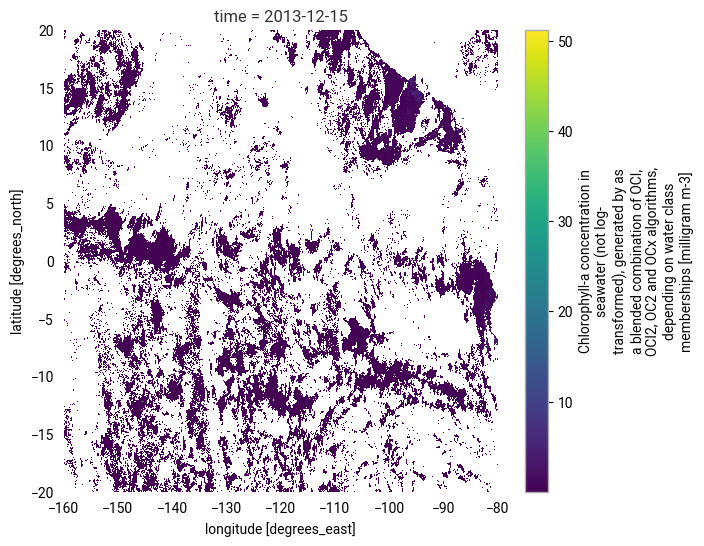

In [7]:
# Choose "chlor_a" or "analysed_sst" depending on selection from above
ds["chlor_a"].plot()

The plot shows chlorophyll-a concentration data (not log-transformed) in milligrams per cubic meter (mg m⁻³) from the Ocean Colour dataset for December 15, 2013.<br> 
White areas indicate missing or masked data. The main reasons for these data gaps are cloud cover, sun glint, daily variability in atmospheric conditions, and satellite coverage. 

**To address these gaps, we will use monthly aggregated composites for subsequent spatial analysis.**

## 3. Understanding Chlorophyll-a and Sea Surface Temperature during El Niño and La Niña events

In this section, we will study the **daily-temporal** and **monthly-spatical** dynamics of Chlorophyll-a and Sea Surface Temperature during the month December in an El Nino (2015) and a La Nina (1999) year compared to a "neutral" year (2013).

### 3.1 Create a daily time series

In this first analysis, we will plot the daily data as time series, allowing us to observe the variations in `chlor_a` concentrations and `analysed_SST` for December across the years. <br> 

A time series analysis is essential for understanding temporal fluctuations and identifying trends that may be influenced by climatic events such as El Niño and La Niña. By examining daily variations, we can capture the timing and intensity of anomalies, as well as their persistence and recovery periods. Comparing these patterns across the specified years (1999, 2013, 2015) provides insight into how these climate events affect ocean conditions on a day-to-day basis.

To do that, we will first define a function to load and process our downloaded December data:

In [8]:
# Function to load and process December data
def load_december_data(base_path, var_name):
    data_dict = {}
    years = {"1999-12": "La Niña", "2013-12": "Neutral", "2015-12": "El Niño"}

    for year, phase in years.items():
        file_pattern = f"{base_path}/{year}/*.nc"
        files = glob.glob(file_pattern)

        if not files:
            print(f"No files found in {file_pattern}")
            continue

        ds = xr.open_mfdataset(files, combine="by_coords")
        ds = ds.sel(time=ds.time.dt.month == 12)

        # Reduce spatial dimensions (lat, lon) to a single value per time step using the mean
        ds_mean = ds[var_name].mean(dim=["lat", "lon"])

        data_dict[(int(year[: 4]), phase)] = ds_mean

    return data_dict

Now, we will load our daily data and create two time series plots using the function from above:

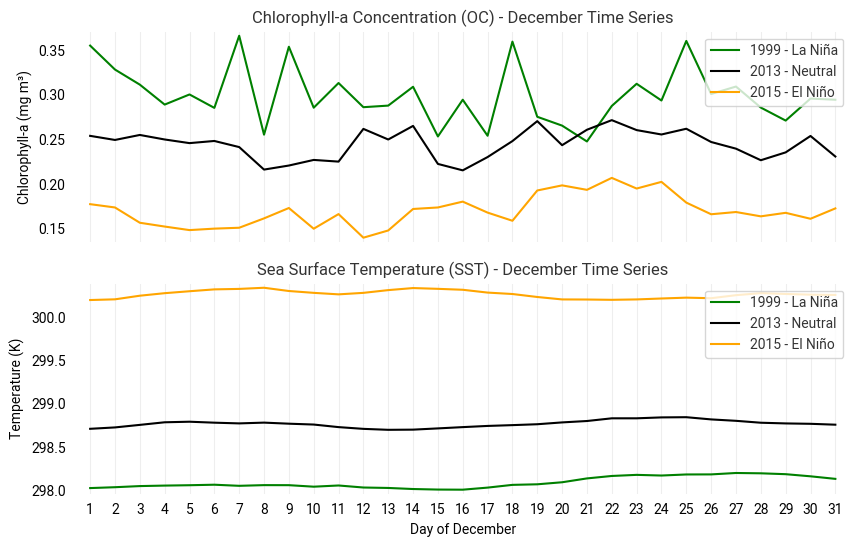

In [9]:
# Load OC (chlorophyll-a) and SST (sea surface temperature) data
oc_data = load_december_data("./data_cds_oc", "chlor_a")
sst_data = load_december_data("./data_cds_sst", "analysed_sst")

# Define colors:
# Green shades for OC, Orange shades for SST
oc_colors = {"1999": "green", "2013": "black", "2015": "orange"}
sst_colors = {"1999": "green", "2013": "black", "2015": "orange"}

# Create a figure with two subplots
fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# Plot OC data (Chlorophyll-a)
for (year, phase), ds in oc_data.items():
    axes[0].plot(ds.time.dt.day, ds, label=f"{year} - {phase}", color=oc_colors[str(year)])

# Plot SST data (Sea Surface Temperature)
for (year, phase), ds in sst_data.items():
    axes[1].plot(ds.time.dt.day, ds, label=f"{year} - {phase}", color=sst_colors[str(year)])

# Set titles and labels
axes[0].set_title("Chlorophyll-a Concentration (OC) - December Time Series")
axes[1].set_title("Sea Surface Temperature (SST) - December Time Series")

# Format x-axis to show only "December days"
axes[1].set_xlabel("Day of December")
axes[1].set_xticks(range(1, 32))

# Configure legends
for ax in axes:
    ax.set_ylabel("Chlorophyll-a (mg m³)" if ax == axes[0] else "Temperature (K)")
    ax.grid()
    ax.legend(loc="upper right")

plt.show()

The two plots display the time series of **Chlorophyll-a Concentration (OC)** and **Sea Surface Temperature (SST)** for December in different years associated with La Niña (1999), Neutral (2013), and El Niño (2015) conditions in the equatorial Pacific area that we have selected.

1. **Chlorophyll-a Concentration (Top Plot)**
   - **La Niña (1999, Green)**: Higher and more variable chlorophyll-a concentrations indicate stronger upwelling and increased nutrient availability, promoting phytoplankton growth.
   - **Neutral (2013, Black)**: Moderate concentrations.
   - **El Niño (2015, Orange)**: Lower chlorophyll-a levels suggest suppressed upwelling, leading to reduced nutrient availability and less phytoplankton activity.

2. **Sea Surface Temperature (Bottom Plot)**
   - **La Niña (1999, Green)**: Cooler SSTs align with intensified upwelling, bringing colder, nutrient-rich waters to the surface.
   - **Neutral (2013, Black)**: Intermediate SSTs.
   - **El Niño (2015, Orange)**: Warmer SSTs, typical of El Niño conditions, where upwelling is weakened due to a deeper thermocline, reducing nutrient availability and biological productivity.

This analysis confirms the typical effects of **El Niño** (warmer SSTs, lower chlorophyll) and **La Niña** (cooler SSTs, higher chlorophyll) on oceanic conditions, illustrating their significant influence on marine ecosystems.

### 3.2 Analyse spatial distribution of monthly averages

In this section, we will visualise and analyse the spatial distribution of Chlorophyll-a and Sea Surface Temperature during El Niño (2015) and La Niña (1999) events compared to a "neutral" year (2013). By comparing these events to a neutral year, we can better understand how anomalous climate phenomena affect the distribution of key ocean variables, which is crucial for ecosystem management, climate modeling, and assessing the impacts of climate variability.

A spatial assessment of chlorophyll-a and sea surface temperature is crucial for understanding how these variables vary across different regions of the ocean during El Niño and La Niña events. Spatial patterns reveal localised changes in ocean productivity and thermal structure that are not evident from temporal averages alone. This approach allows us to identify regions most affected by climate anomalies, such as shifts in upwelling zones and changes in nutrient availability.

#### Aggregate daily into monthly data

We want to aggregate the daily to monthly mean datasets for each December of 1999, 2013 and 2015 to continue with the analysis of the spatial distribution of `chlor_a` and `analysed_SST` variables.

The script provided here aggregates daily data into monthly means for December of 1999, 2013, and 2015. It saves the results in new NetCDF files for further spatial analysis.

The following steps are made to get the monthly data:
1. **Define Input/Output Paths**: Specifies where to find and save the data.
2. **Ensure Directories**: Creates output directories if they don't exist.
3. **Process Data**:  
   - Loops through specified months.  
   - Loads daily data using `xarray`.  
   - Computes monthly means.
4. **Save Results**: Saves the aggregated data in NetCDF format.

In [10]:
# Define input and output paths
input_dirs = {"oc": "./data_cds_oc", "sst": "./data_cds_sst"}
output_dirs = {
    "oc": "./data_cds_monthly/monthly_oc",
    "sst": "./data_cds_monthly/monthly_sst",
}
var_names = {"oc": "chlor_a", "sst": "analysed_sst"}

# Ensure output directories exist
for out_dir in output_dirs.values():
    os.makedirs(out_dir, exist_ok=True)


def process_monthly_means(base_path, output_path, var_name):
    """Processes daily NetCDF files, calculates monthly means, and saves as new files."""
    for folder in ["1999-12", "2013-12", "2015-12"]:
        folder_path = os.path.join(base_path, folder)

        files = sorted(
            [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(".nc")]
        )

        if not files:
            print(f"No files found in {folder_path}, skipping...")
            continue

        # Open multiple NetCDF files as one dataset
        ds = xr.open_mfdataset(files, combine="by_coords")

        # Compute the monthly mean
        ds_monthly = ds[var_name].resample(time="ME").mean()

        # Save the output file
        year_month = folder  # Example: "1999-12"
        output_file = os.path.join(output_path, f"{var_name}_{year_month}.nc")
        ds_monthly.to_netcdf(output_file)

        print(f"Saved: {output_file}")


# Process OC and SST data
process_monthly_means(input_dirs["oc"], output_dirs["oc"], var_names["oc"])
process_monthly_means(input_dirs["sst"], output_dirs["sst"], var_names["sst"])

Saved: ./data_cds_monthly/monthly_oc/chlor_a_1999-12.nc
Saved: ./data_cds_monthly/monthly_oc/chlor_a_2013-12.nc
Saved: ./data_cds_monthly/monthly_oc/chlor_a_2015-12.nc
Saved: ./data_cds_monthly/monthly_sst/analysed_sst_1999-12.nc
Saved: ./data_cds_monthly/monthly_sst/analysed_sst_2013-12.nc
Saved: ./data_cds_monthly/monthly_sst/analysed_sst_2015-12.nc


#### Create monthly average maps

Visualizing **monthly average Chlorophyll-a concentration** and **Sea Surface Temperature (SST)** helps to understand oceanographic conditions under different climate events like **La Niña (1999), Neutral (2013), and El Niño (2015)**. These maps provide insights into:
- Variations in **biological productivity** (by proxy of Chlorophyll-a).
- Variations in **ocean temperature** (SST).

We will create six monthly maps in one figure following these steps:
1. Load **December** data for each year.
2. Use **LogNorm** for Chlorophyll-a to account for the large dynamic range.
3. Use **consistent color scales** across years for easy comparison.
4. Arrange maps in a **3x2 grid**:
   - **Left column:** Chlorophyll-a
   - **Right column:** SST

/var/folders/kx/ksg5wbrj1sq95rp2tz_72j6c0000gn/T/ipykernel_3710/935103404.py:86: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Roboto.
  plt.tight_layout()
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 8315 (\N{SUPERSCRIPT MINUS}) missing from font(s) Roboto.
  fig.canvas.print_figure(bytes_io, **kw)


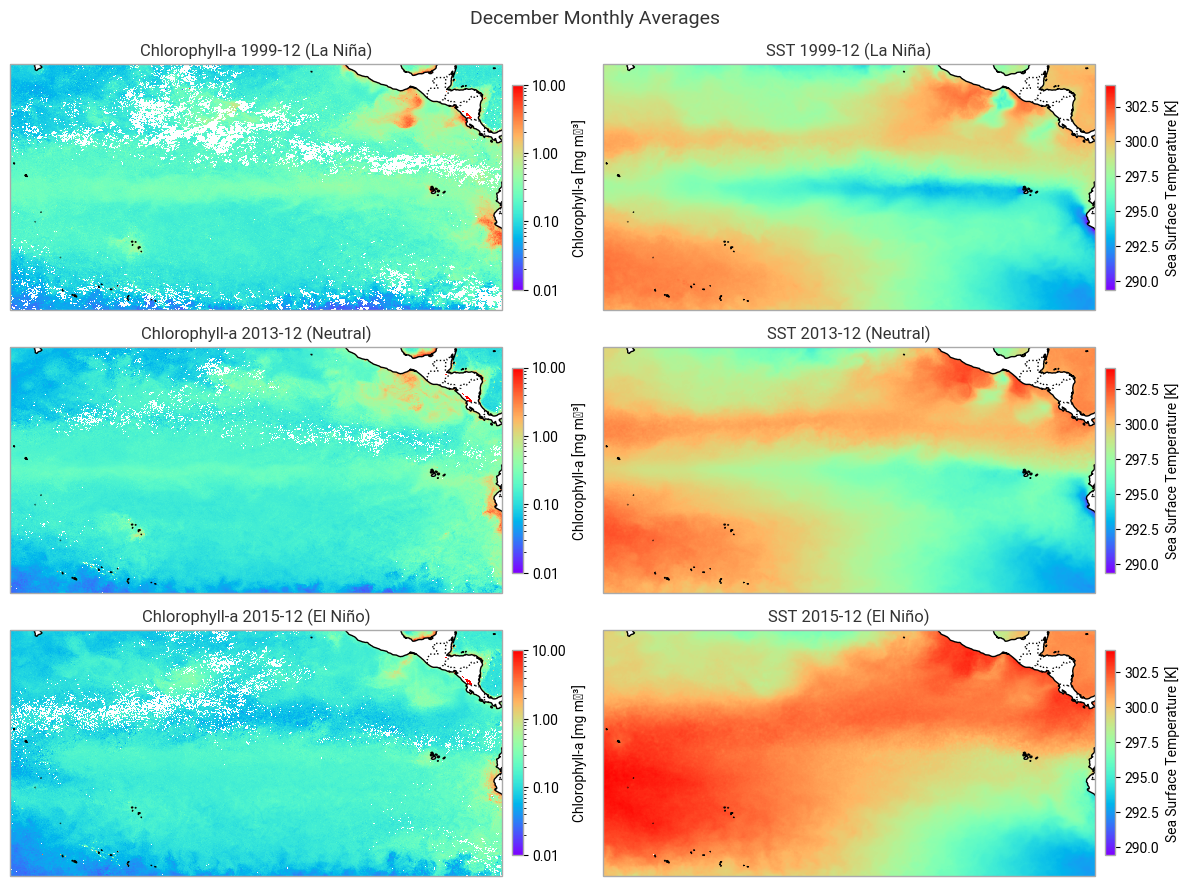

In [11]:
# Define paths to monthly data
base_dir = "./data_cds_monthly"
oc_files = [
    os.path.join(base_dir, "monthly_oc", f"chlor_a_{year}-12.nc")
    for year in [1999, 2013, 2015]
]
sst_files = [
    os.path.join(base_dir, "monthly_sst", f"analysed_sst_{year}-12.nc")
    for year in [1999, 2013, 2015]
]

# Open datasets
oc_datasets = [xr.open_dataset(f) for f in oc_files]
sst_datasets = [xr.open_dataset(f) for f in sst_files]

# Define figure and axes (3x2 grid)
fig, axes = plt.subplots(
    3, 2, figsize=(12, 9), subplot_kw={"projection": ccrs.PlateCarree()}
)
fig.suptitle("December Monthly Averages", fontsize=14)


# Function to plot data
def plot_map(ax, ds, var_name, title, cmap, norm=None):
    """Plots a map with data from a given NetCDF dataset."""
    data = ds[var_name].squeeze()
    lat = ds.lat if "lat" in ds else ds.latitude
    lon = ds.lon if "lon" in ds else ds.longitude

    img = ax.pcolormesh(
        lon, lat, data, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm
    )
    ax.set_title(title, fontsize=12)
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=":")
    return img


# Define labels for each year
labels = {1999: "La Niña", 2013: "Neutral", 2015: "El Niño"}

# Define colormaps
chlorophyll_cmap = "rainbow"
sst_cmap = "rainbow"

# Define LogNorm for chlor_a
chlor_norm = LogNorm(vmin=0.01, vmax=10)

# Plot Chlorophyll-a (left column)
for i, (ds, year) in enumerate(zip(oc_datasets, [1999, 2013, 2015])):
    title = f"Chlorophyll-a {year}-12 ({labels[year]})"
    img = plot_map(
        axes[i, 0], ds, "chlor_a", title, chlorophyll_cmap, norm=chlor_norm
    )

    cbar = fig.colorbar(
        img,
        ax=axes[i, 0],
        orientation="vertical",
        fraction=0.02,
        pad=0.02,
        label="Chlorophyll-a [mg m⁻³]",
    )
    cbar.ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f"{y:.2f}"))

# Determine global min/max for SST
sst_min = min(ds["analysed_sst"].min().item() for ds in sst_datasets)
sst_max = max(ds["analysed_sst"].max().item() for ds in sst_datasets)
sst_norm = Normalize(vmin=sst_min, vmax=sst_max)

# Plot SST (right column)
for i, (ds, year) in enumerate(zip(sst_datasets, [1999, 2013, 2015])):
    title = f"SST {year}-12 ({labels[year]})"
    img_sst = plot_map(axes[i, 1], ds, "analysed_sst", title, sst_cmap, norm=sst_norm)

    fig.colorbar(
        img_sst,
        ax=axes[i, 1],
        orientation="vertical",
        fraction=0.02,
        pad=0.02,
        label="Sea Surface Temperature [K]",
    )

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()

In December 1999, during **La Niña**, Chlorophyll-a concentrations were high along the equator and near coastal upwelling zones. The sea surface temperature (SST) was cooler, particularly along the equator, due to the intensified upwelling of deep, cold water.

In December 2013, under **neutral** conditions, Chlorophyll-a levels were intermediate and more evenly distributed across the region. The SST was moderate ocean circulation patterns remained relatively stable.

In December 2015, during **El Niño**, Chlorophyll-a concentrations were significantly reduced in the equatorial Pacific. At the same time, SST was much warmer, with warm water spreading across the central and eastern Pacific, a hallmark of El Niño conditions.

### 3.3 Create anomaly maps

In this section we will create anomaly maps. Anomaly maps are useful for identifying deviations from normal conditions, helping to visualize the impact of climate events like El Niño and La Niña. By comparing **Chlorophyll-a concentration** and **Sea Surface Temperature (SST)** for different years against a neutral reference year, we can assess how ocean conditions deviate during extreme climate events.

We will create four anomaly maps using these steps:
1. Select a **neutral year** (2013) as the baseline.
2. Compute anomalies by subtracting the neutral year's values from those of La Niña (1999) and El Niño (2015).
3. Visualize differences using a diverging colormap (e.g., **red for positive, blue for negative anomalies**).

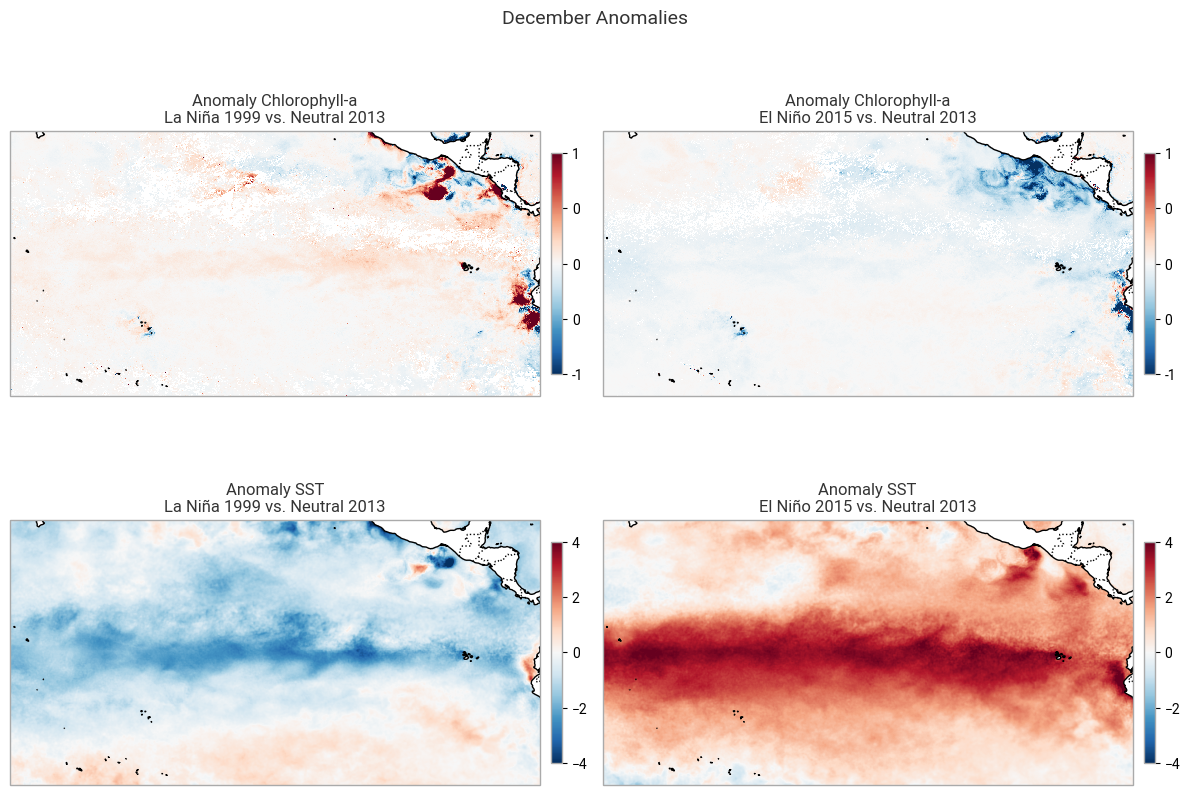

In [12]:
# Neutral data is from 2013
neutral_oc = oc_datasets[1]["chlor_a"].squeeze()
neutral_sst = sst_datasets[1]["analysed_sst"].squeeze()


# Function to calculate anomalies
def calculate_anomalies(data, neutral_data):
    return data - neutral_data


# Function to plot data
def plot_map(ax, data, title, cmap, norm=None):
    lat = data.lat if "lat" in data.coords else data.latitude
    lon = data.lon if "lon" in data.coords else data.longitude

    img = ax.pcolormesh(lon, lat, data, transform=ccrs.PlateCarree(), cmap=cmap, norm=norm)
    ax.set_title(title, fontsize=12)
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    return img


# Create a 2x2 subplot grid for the maps
fig, axes = plt.subplots(2, 2, figsize=(12, 9), subplot_kw={'projection': ccrs.PlateCarree()})
fig.suptitle("December Anomalies", fontsize=14)

# Define diverging colormaps and normalization
chlorophyll_cmap = "RdBu_r"
sst_cmap = "RdBu_r"
chlor_norm = Normalize(vmin=-1, vmax=1)
sst_norm = Normalize(vmin=-4, vmax=4)

# Plot Chlorophyll-a anomaly maps for 1999 vs 2013
oc_anomaly_1999 = calculate_anomalies(
    oc_datasets[0]["chlor_a"].squeeze(), neutral_oc
)
img_oc_1999 = plot_map(
    axes[0, 0], oc_anomaly_1999, "Anomaly Chlorophyll-a\nLa Niña 1999 vs. Neutral 2013",
    chlorophyll_cmap, norm=chlor_norm
)
cbar_oc_1999 = fig.colorbar(
    img_oc_1999, ax=axes[0, 0], orientation="vertical", fraction=0.02, pad=0.02
)
cbar_oc_1999.ax.yaxis.set_major_formatter(
    FuncFormatter(lambda y, _: f'{int(y)}')
)

# Plot SST anomaly maps for 1999 vs 2013
sst_anomaly_1999 = calculate_anomalies(
    sst_datasets[0]["analysed_sst"].squeeze(), neutral_sst
)
img_sst_1999 = plot_map(
    axes[1, 0], sst_anomaly_1999, "Anomaly SST\nLa Niña 1999 vs. Neutral 2013",
    sst_cmap, norm=sst_norm
)
cbar_sst_1999 = fig.colorbar(
    img_sst_1999, ax=axes[1, 0], orientation="vertical", fraction=0.02, pad=0.02
)

# Plot Chlorophyll-a anomaly maps for 2015 vs 2013
oc_anomaly_2015 = calculate_anomalies(
    oc_datasets[2]["chlor_a"].squeeze(), neutral_oc
)
img_oc_2015 = plot_map(
    axes[0, 1], oc_anomaly_2015, "Anomaly Chlorophyll-a\nEl Niño 2015 vs. Neutral 2013",
    chlorophyll_cmap, norm=chlor_norm
)
cbar_oc_2015 = fig.colorbar(
    img_oc_2015, ax=axes[0, 1], orientation="vertical", fraction=0.02, pad=0.02
)
cbar_oc_2015.ax.yaxis.set_major_formatter(
    FuncFormatter(lambda y, _: f'{int(y)}')
)

# Plot SST anomaly maps for 2015 vs 2013
sst_anomaly_2015 = calculate_anomalies(
    sst_datasets[2]["analysed_sst"].squeeze(), neutral_sst
)
img_sst_2015 = plot_map(
    axes[1, 1], sst_anomaly_2015, "Anomaly SST\nEl Niño 2015 vs. Neutral 2013",
    sst_cmap, norm=sst_norm
)
cbar_sst_2015 = fig.colorbar(
    img_sst_2015, ax=axes[1, 1], orientation="vertical", fraction=0.02, pad=0.02
)

# Plot layout
plt.tight_layout()
plt.show()

These maps highlights the anomalies in **Chlorophyll-a concentration** (mg m-3) and **Sea Surface Temperature (SST)** (K) for December, comparing the conditions during La Niña (1999) and El Niño (2015) to the neutral year of 2013. The left column represents deviations observed during La Niña, while the right column shows anomalies associated with El Niño.

- The **Chlorophyll-a anomaly maps** in the top row reveal distinct differences in biological productivity. During **La Niña in 1999**, positive anomalies (red areas) indicate increased Chlorophyll-a concentrations, particularly along the equatorial Pacific and coastal upwelling regions. This increase is due to stronger trade winds that enhance upwelling, bringing nutrient-rich waters to the surface and supporting higher phytoplankton growth. In contrast, during **El Niño in 2015**, negative anomalies (blue areas) dominate, showing a decline in Chlorophyll-a concentrations. This reduction results from weakened upwelling and decreased nutrient availability, leading to lower biological productivity in the eastern Pacific.

- The **SST anomaly maps** in the bottom row highlight the contrasting temperature patterns associated with La Niña and El Niño. In **La Niña (1999), negative SST anomalies** (blue areas) indicate cooler-than-average sea surface temperatures, particularly in the central and eastern Pacific. These cooler temperatures are a direct result of enhanced upwelling, which brings cold, deep ocean water to the surface. In contrast, **El Niño (2015) is characterized by strong positive SST anomalies** (red areas), with temperature increases exceeding **+4°C** across the central and eastern Pacific. This warming disrupts normal oceanic circulation and weakens the upwelling process, leading to significant climate and ecosystem impacts.

These anomaly maps clearly illustrate the **opposing effects of La Niña and El Niño** on ocean temperatures and marine productivity. La Niña promotes stronger upwelling, cooler temperatures, and increased Chlorophyll-a concentrations, while El Niño leads to significant ocean warming

## 4. Conculsion

In this notebook, we provide use cases based on the Ocean Colour (variable `chlor_a`) and Sea Surface Temperature (variable `analysed_sst`) datasets to illustrate how these CDS datasets can be used to study, analyze, and visualize the impacts of El Niño and La Niña events. 

The current datasets show variations in chlorophyll-a and sea surface temperature patterns over time, with significant changes associated with major climate phenomena. By comparing these patterns during El Niño and La Niña years, we can explore the relationships between these events and marine ecosystem dynamics, as well as global climate patterns.

Comparisons with other independent datasets can help further investigate the trends and anomalies caused by these climate events, providing insight into the broader impacts on ocean health, weather systems, and the global climate.
